# Please read the [README](https://github.com/ibudiselic/covid/blob/master/README.md) file in this repository.

In [1]:
# Load all the data and functionality.
%run lib.ipynb

countries_to_plot = ['Croatia', 'Switzerland', 'Italy', 'US', 'United Kingdom', 'Sweden']

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Cross-country comparison over absolute dates

## Confirmed

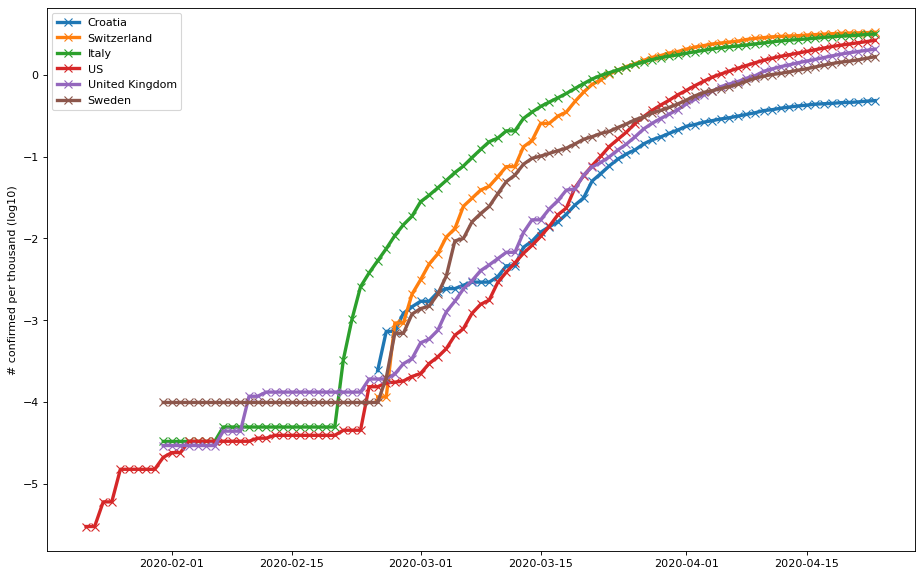

## Dead

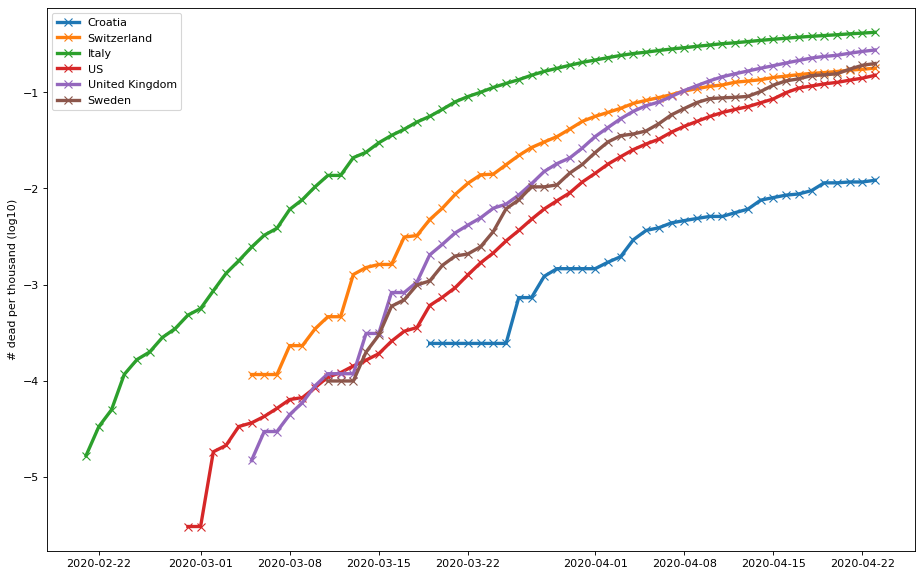

In [3]:
for series in ['confirmed', 'dead']:
    compare_countries_absolute_dates(series)

# Cross-country comparison with approximately aligned start days

## Confirmed

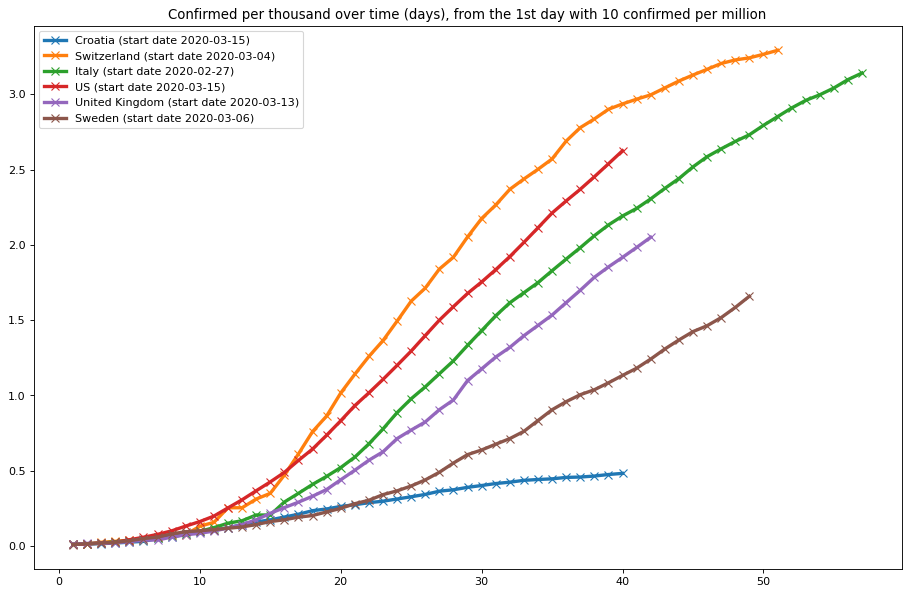

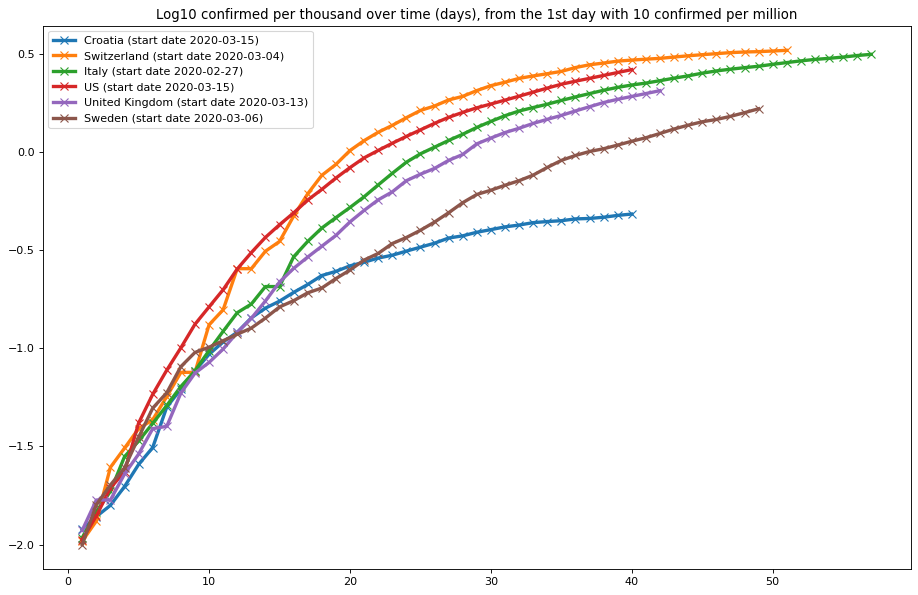

In [4]:
compare_countries_relative_dates('confirmed', start_info=(0.01, '10 confirmed per million'))

## Dead

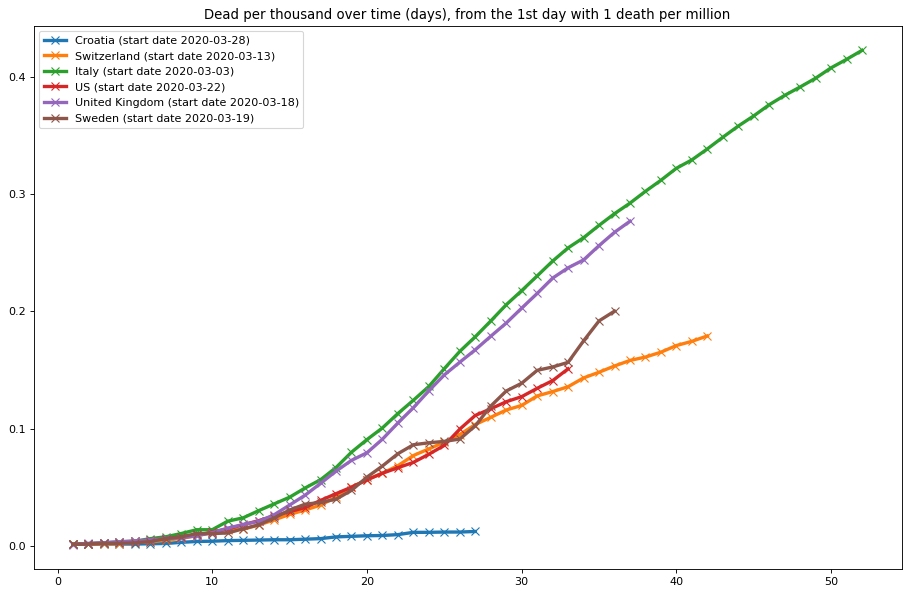

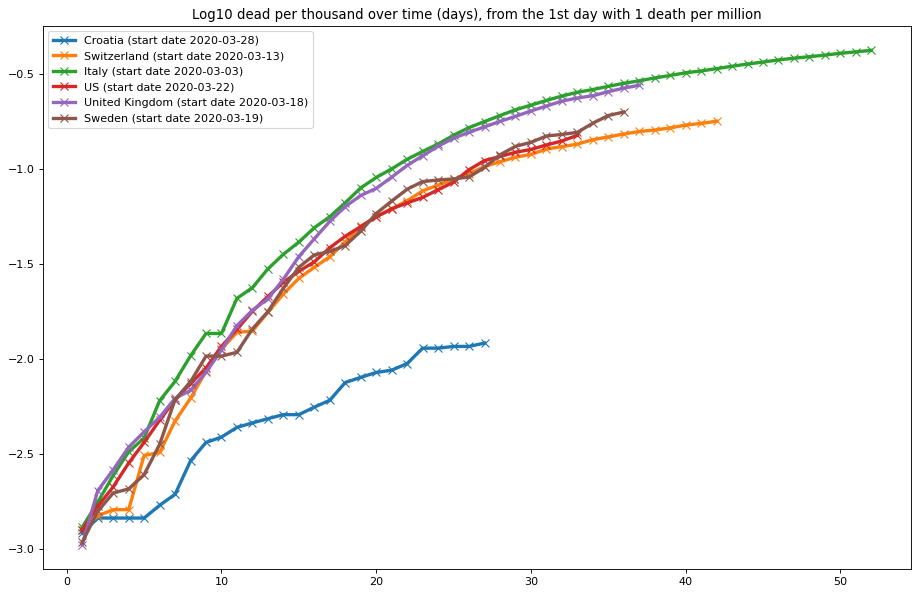

In [5]:
compare_countries_relative_dates('dead', start_info=(0.001, '1 death per million'))

# Per-country analysis with exponential and sigmoidal projections, and new cases analysis

<span style="color:red;">
IMPORTANT: The projections are only accurate if the fit is good (it often isn't), and assuming nothing changes
going forward. The sigmoid is omitted if a reasonable fit can't be computed, but this still doesn't mean that
the fit is good if it is shown.
</span>
                 
The dashed lines show best fit projections from a few previous days for comparison.

## Croatia

Population \\(4,105,267\\)

### Confirmed

Start date 2020-02-28 (1st day with 1 confirmed per million)

Latest number \\(1,981\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

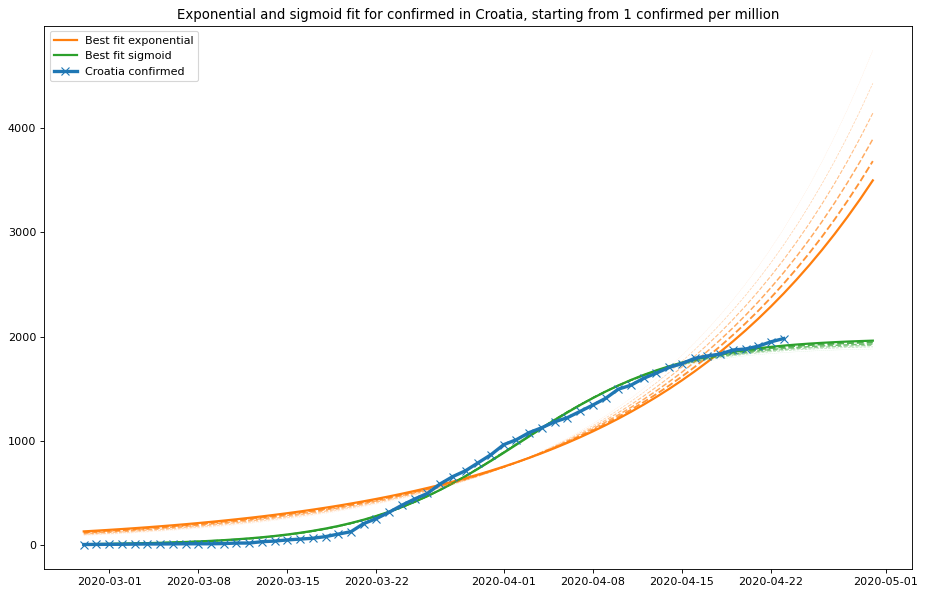

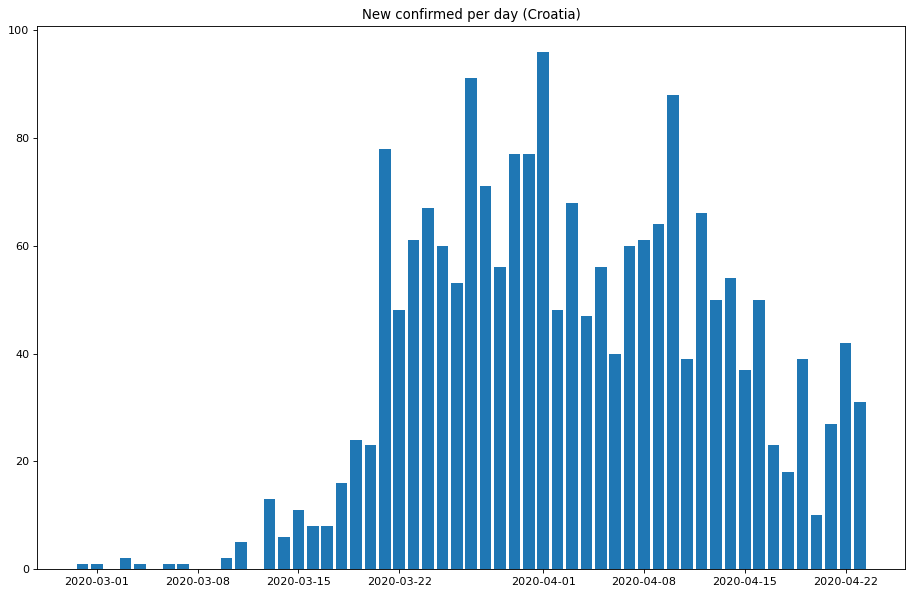

### Dead

Start date 2020-03-19 (1st day with 0.1 dead per million)

Latest number \\(50\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

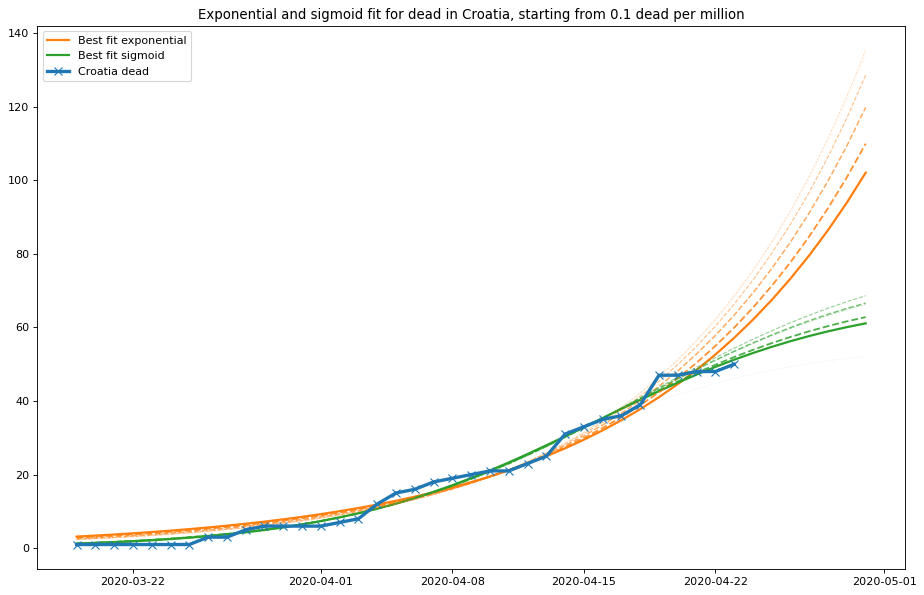

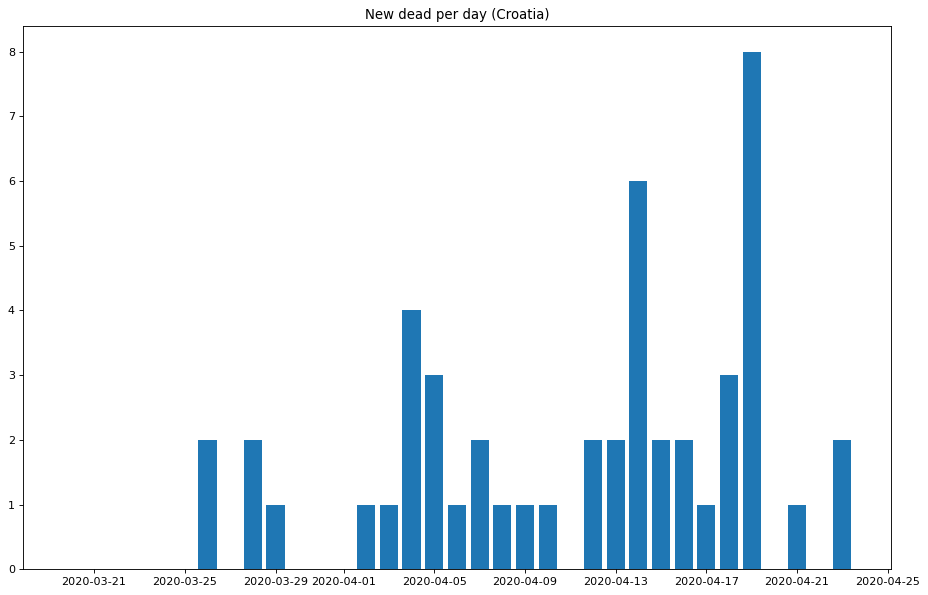

### Active

Start date 2020-02-28 (1st day with 1 active per million)

Latest number \\(1,048\\) on 2020-04-23

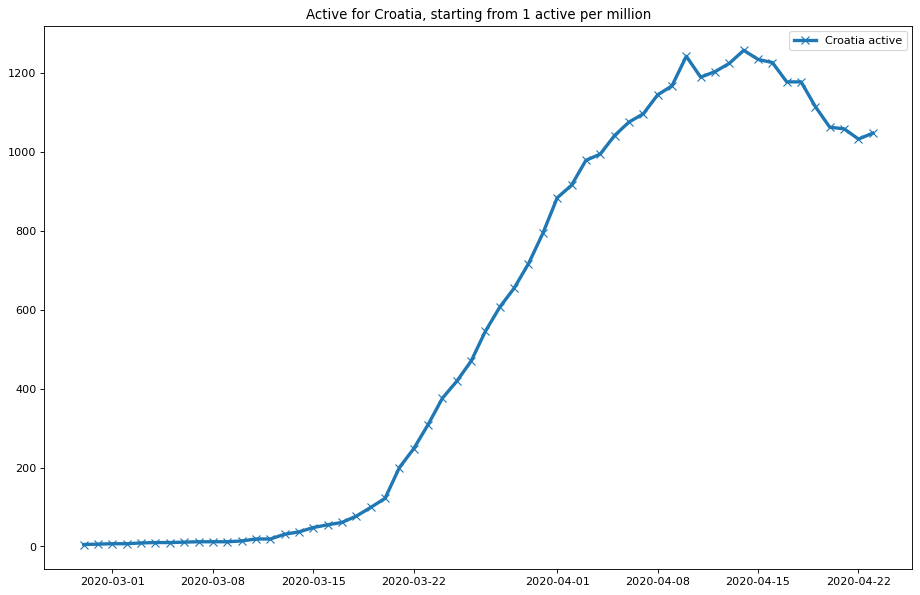

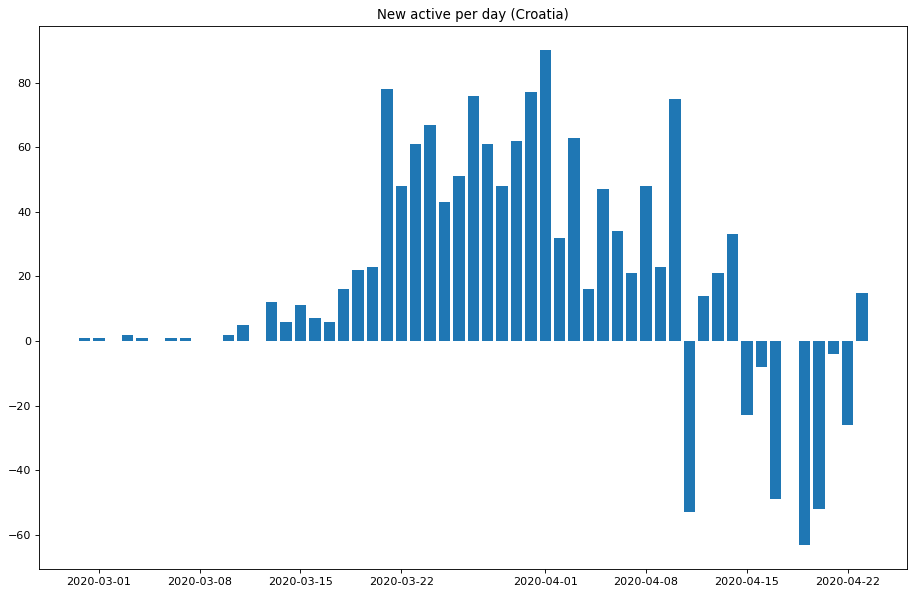

## Switzerland

Population \\(8,654,622\\)

### Confirmed

Start date 2020-02-29 (1st day with 1 confirmed per million)

Latest number \\(28,496\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

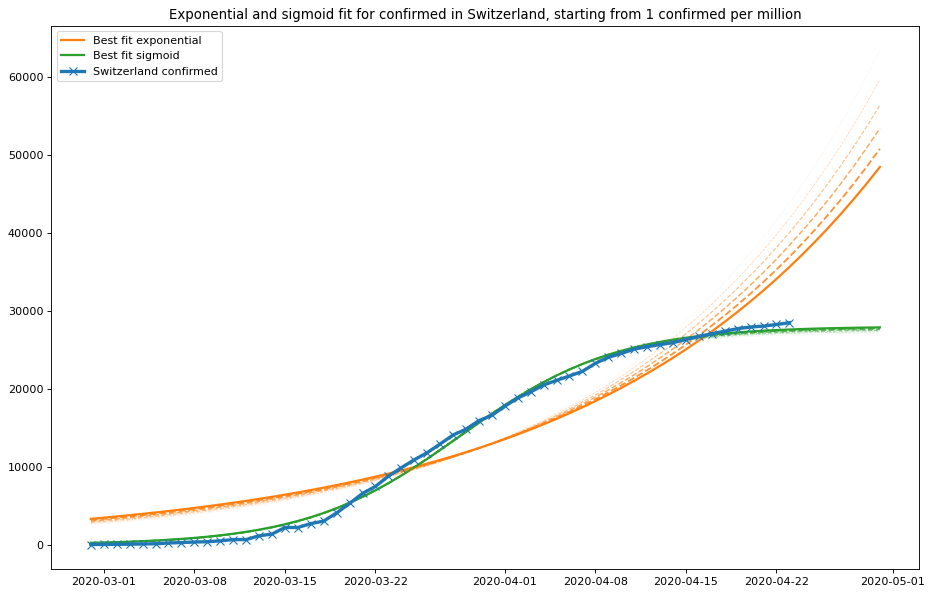

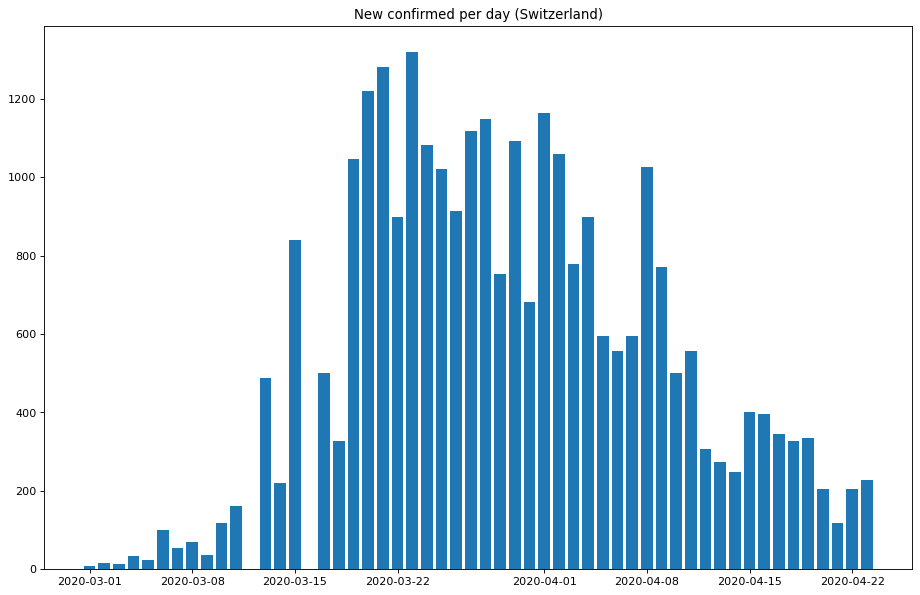

### Dead

Start date 2020-03-05 (1st day with 0.1 dead per million)

Latest number \\(1,549\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

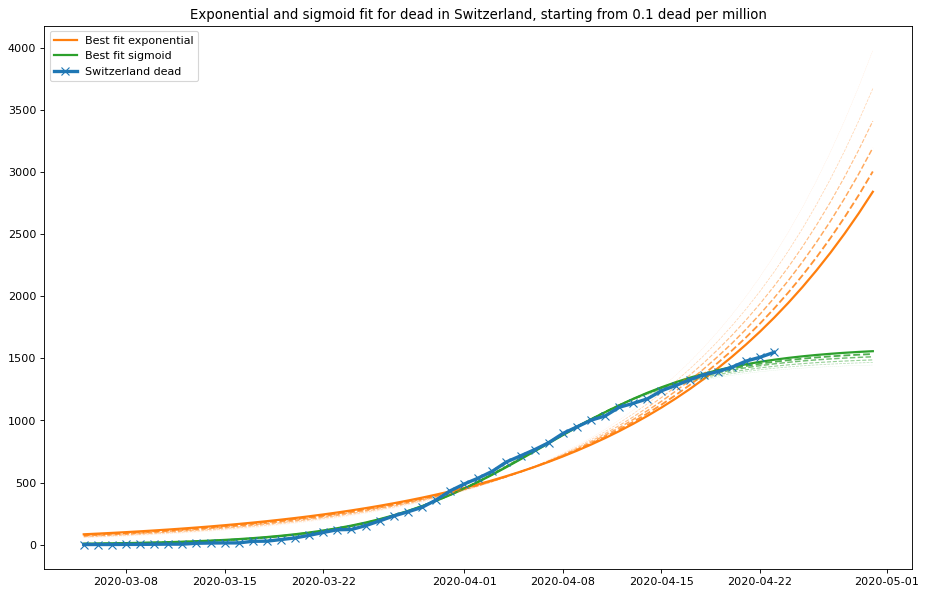

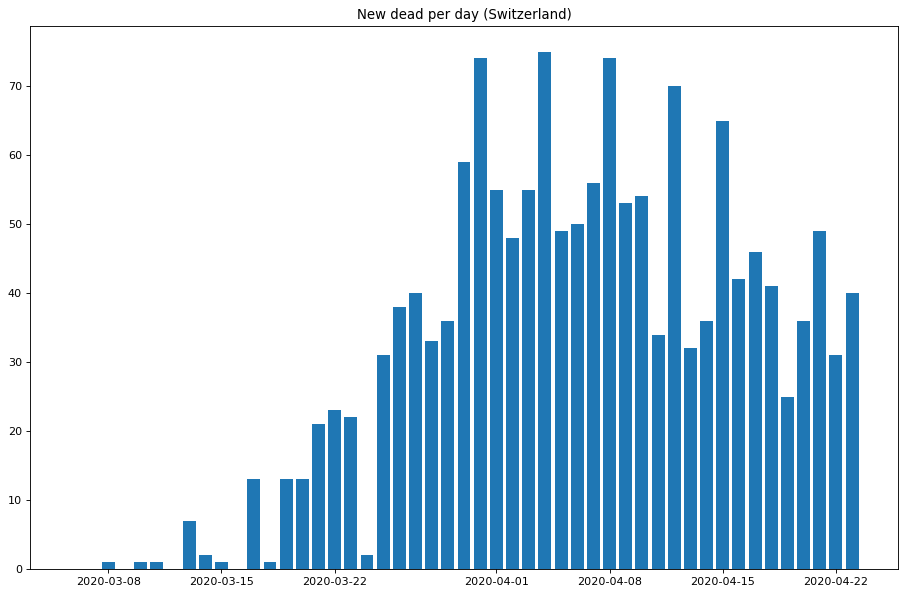

### Active

Start date 2020-02-29 (1st day with 1 active per million)

Latest number \\(6,347\\) on 2020-04-23

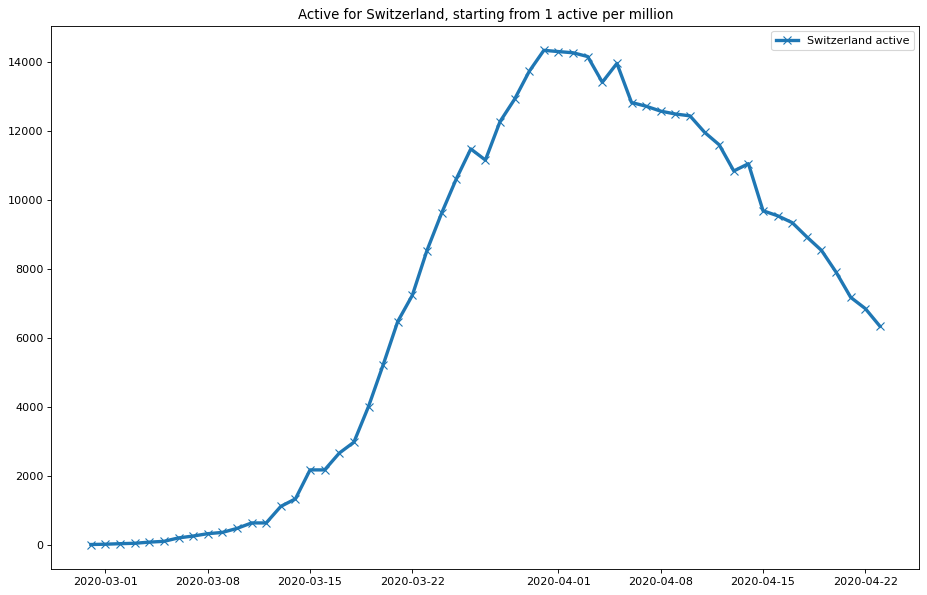

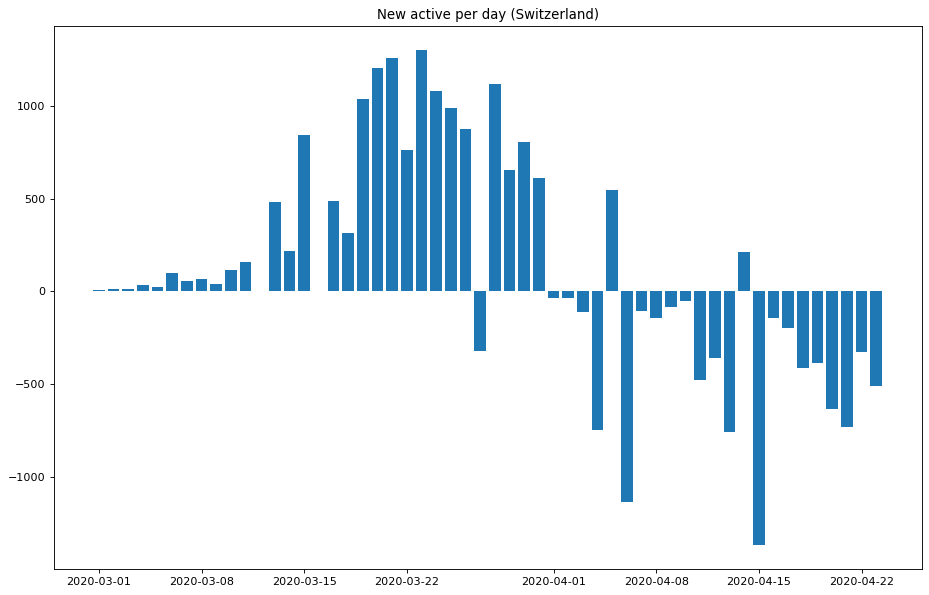

## Italy

Population \\(60,461,826\\)

### Confirmed

Start date 2020-02-22 (1st day with 1 confirmed per million)

Latest number \\(189,973\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

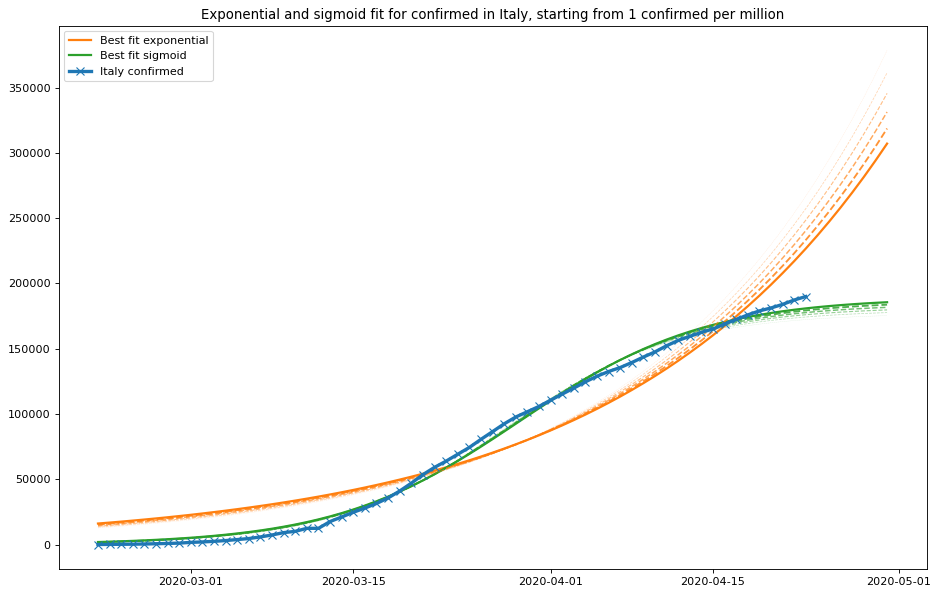

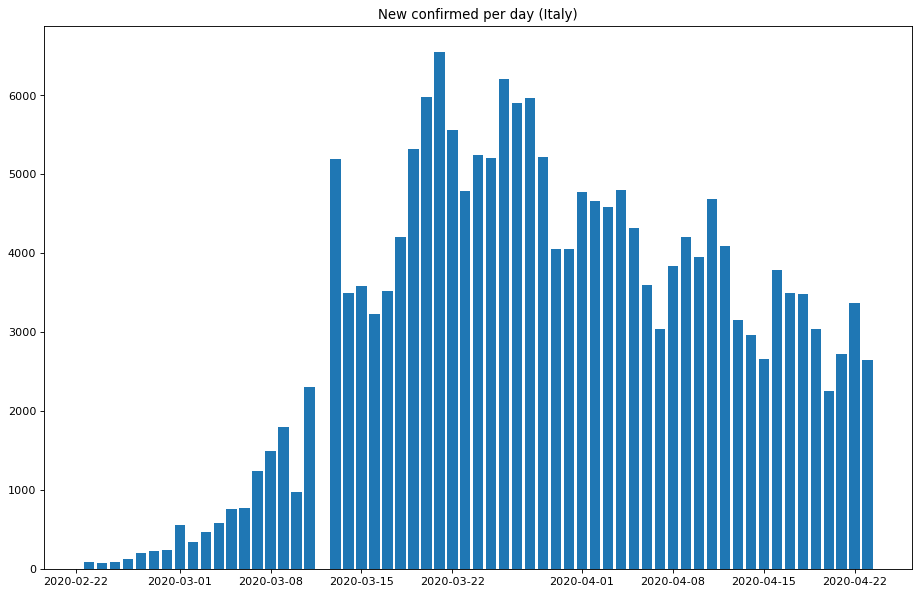

### Dead

Start date 2020-02-24 (1st day with 0.1 dead per million)

Latest number \\(25,549\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

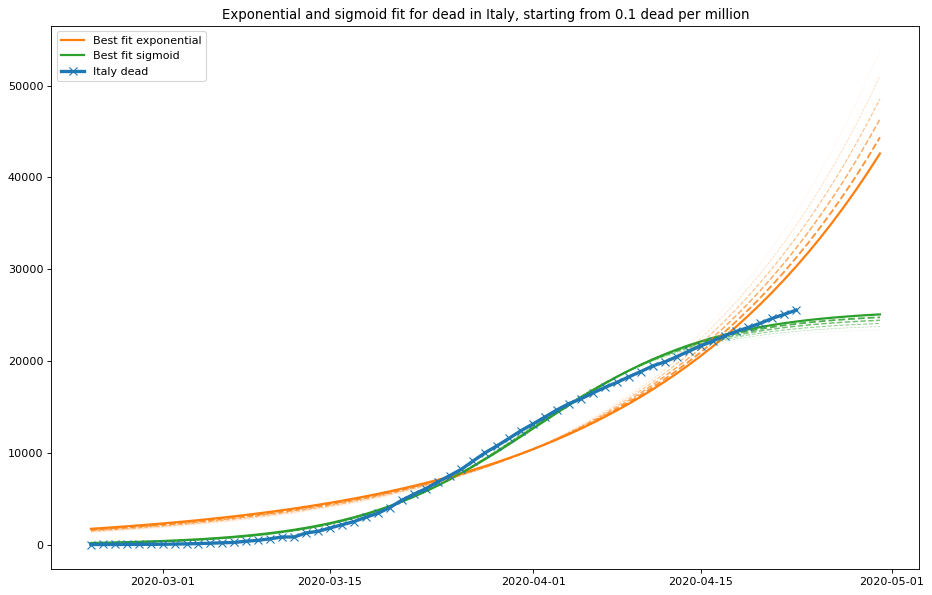

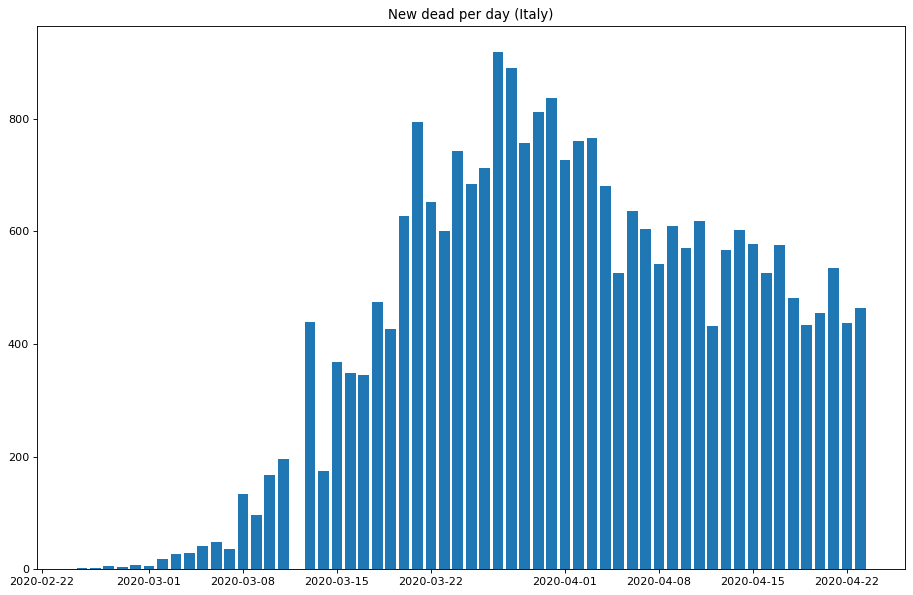

### Active

Start date 2020-02-23 (1st day with 1 active per million)

Latest number \\(106,848\\) on 2020-04-23

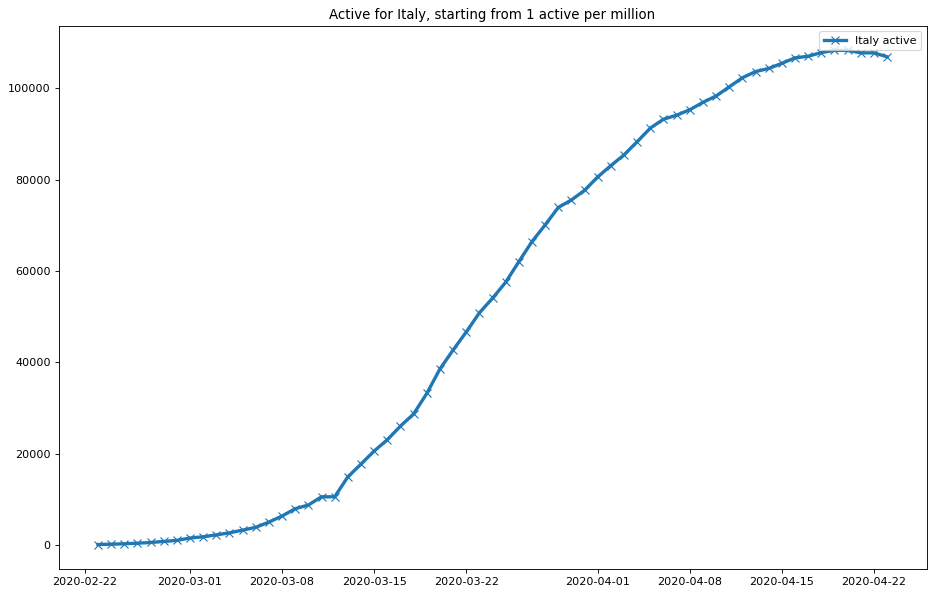

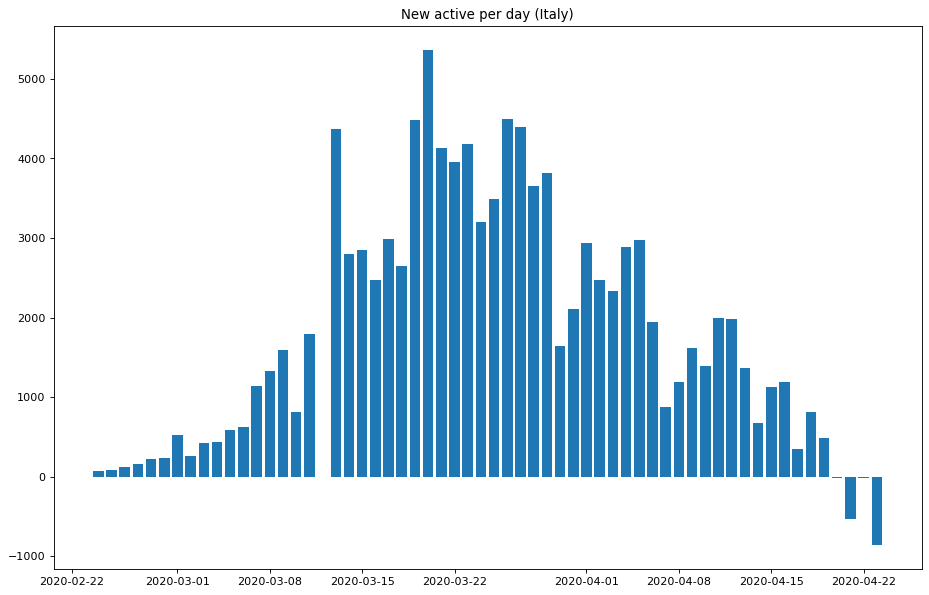

## US

Population \\(331,002,651\\)

### Confirmed

Start date 2020-03-07 (1st day with 1 confirmed per million)

Latest number \\(869,170\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

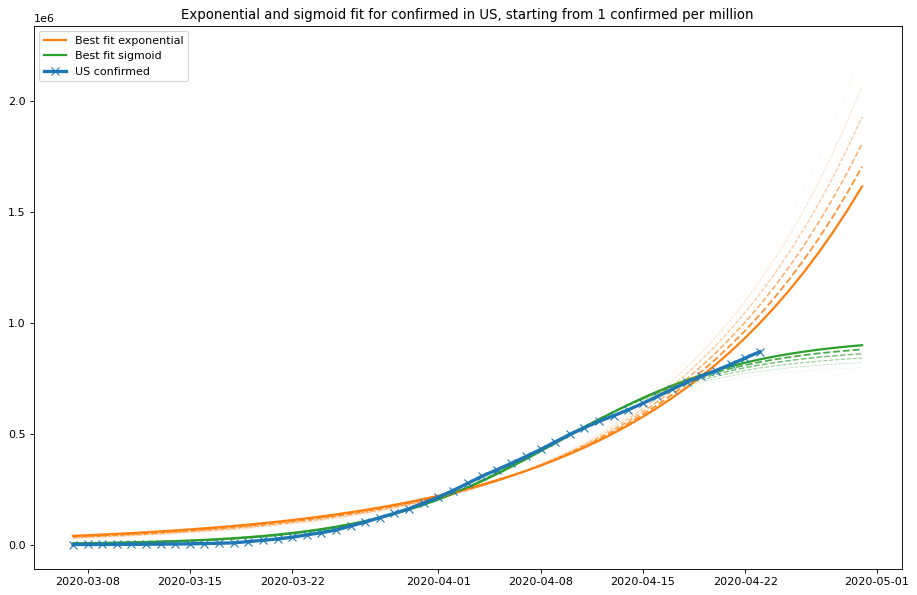

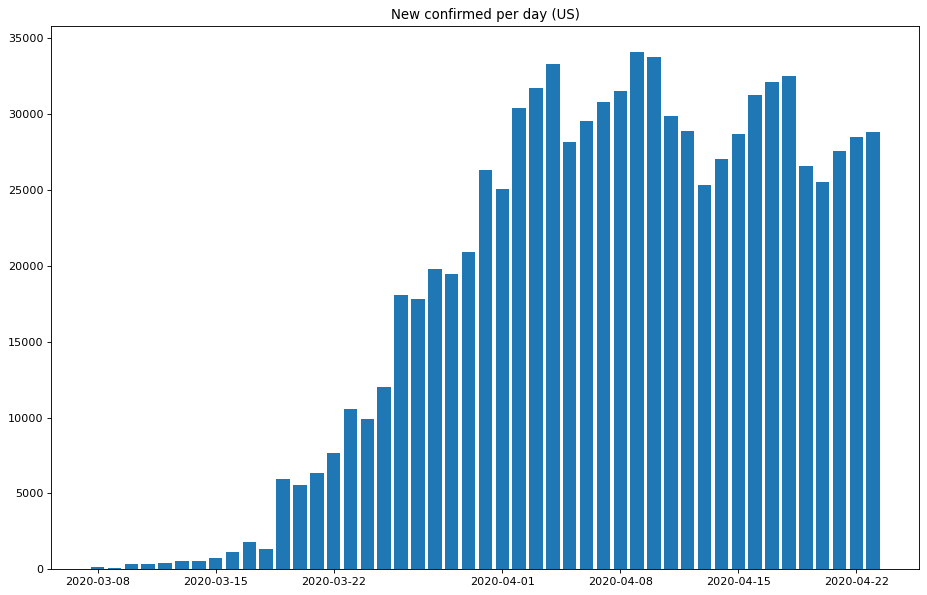

### Dead

Start date 2020-03-11 (1st day with 0.1 dead per million)

Latest number \\(49,954\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

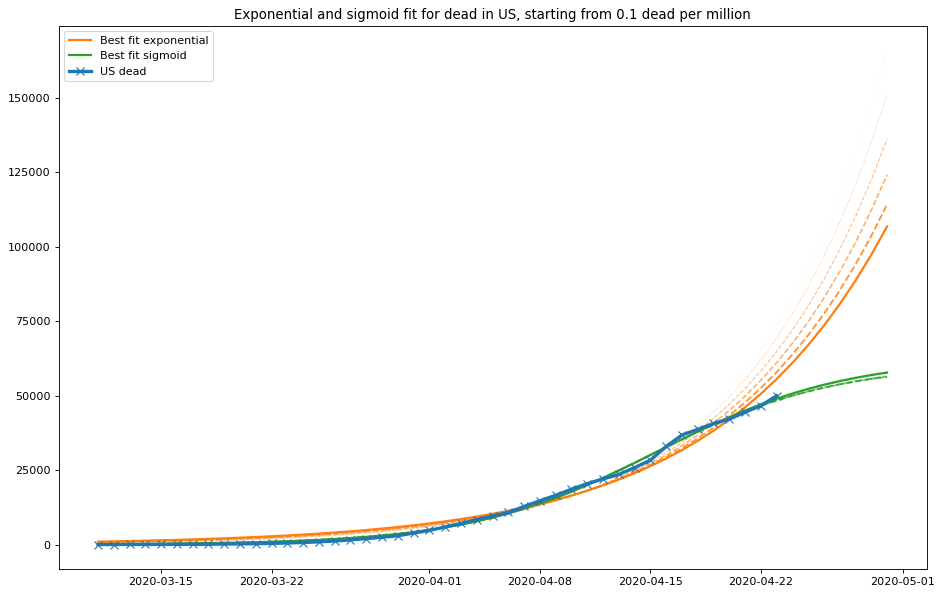

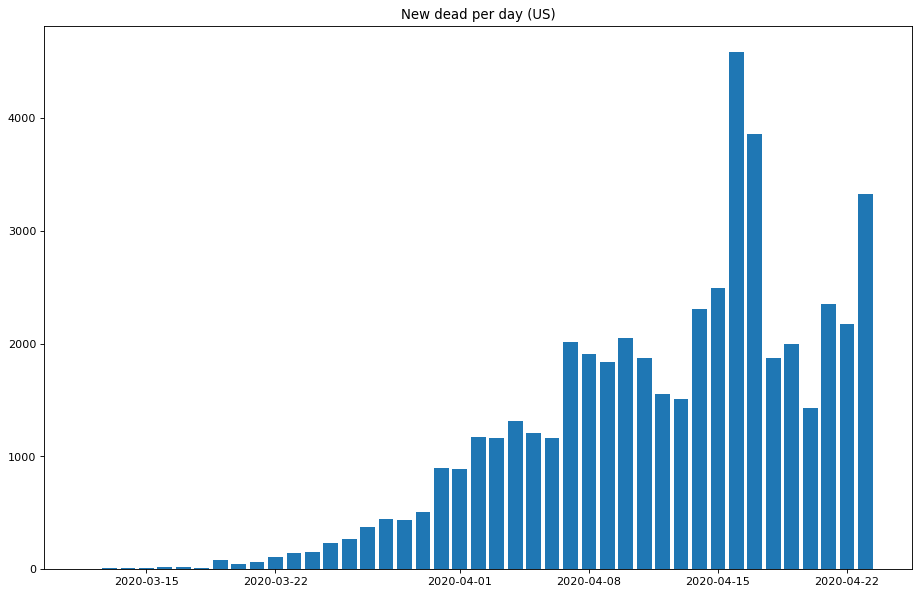

### Active

Start date 2020-03-07 (1st day with 1 active per million)

Latest number \\(739,013\\) on 2020-04-23

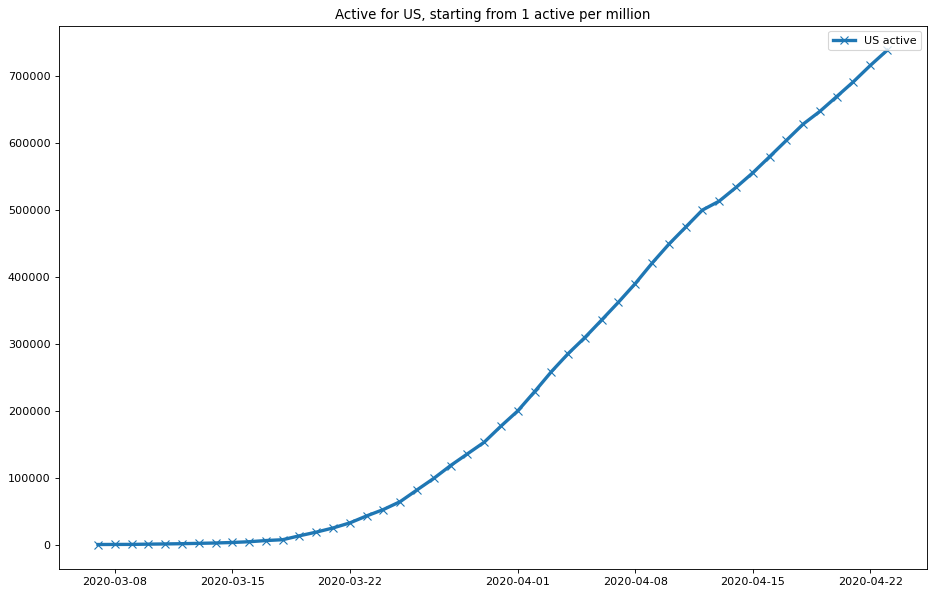

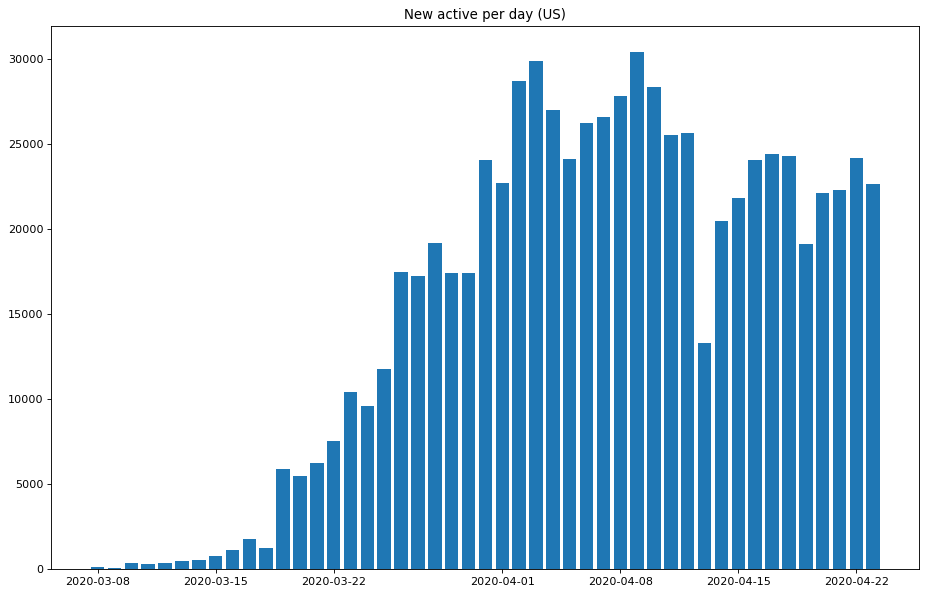

## United Kingdom

Population \\(67,886,011\\)

### Confirmed

Start date 2020-03-04 (1st day with 1 confirmed per million)

Latest number \\(139,246\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

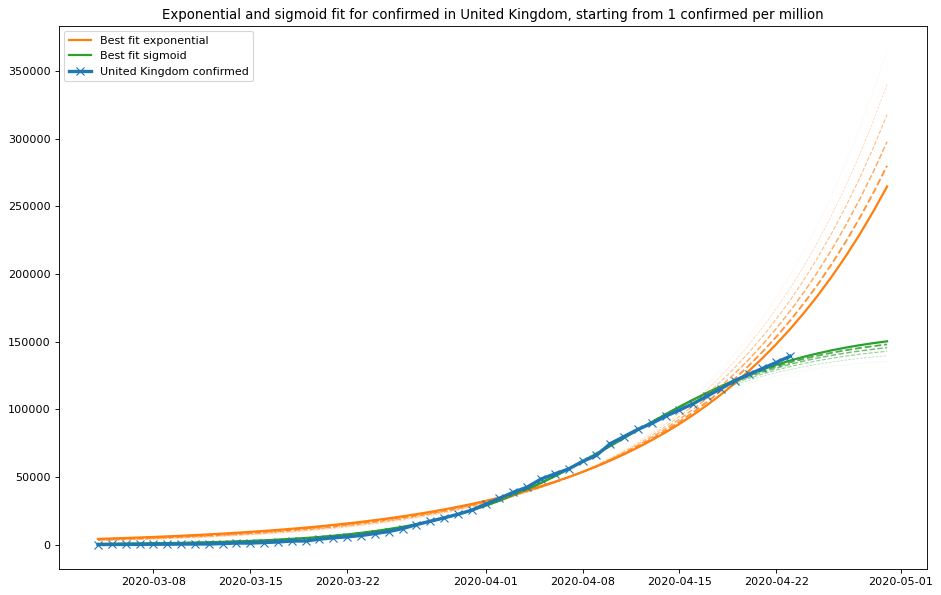

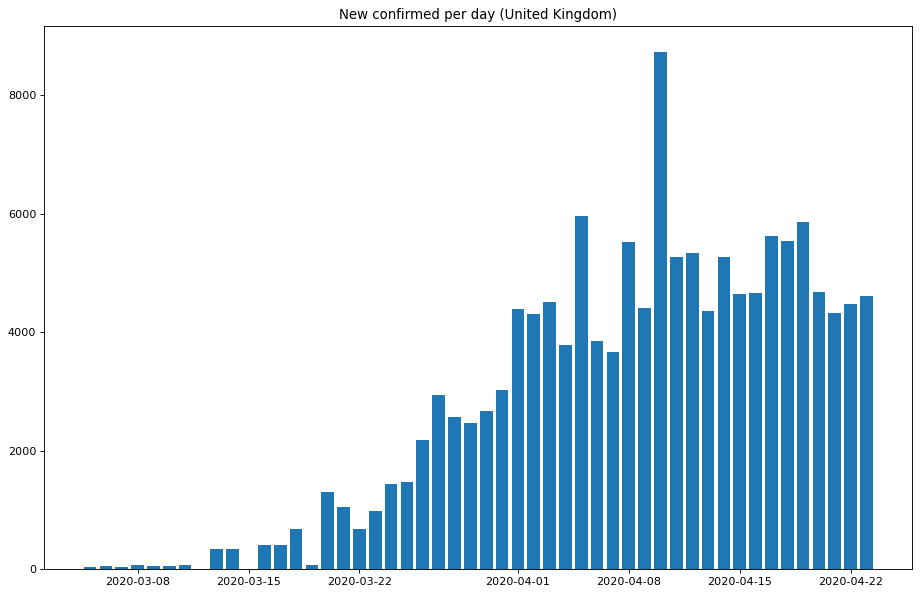

### Dead

Start date 2020-03-11 (1st day with 0.1 dead per million)

Latest number \\(18,791\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

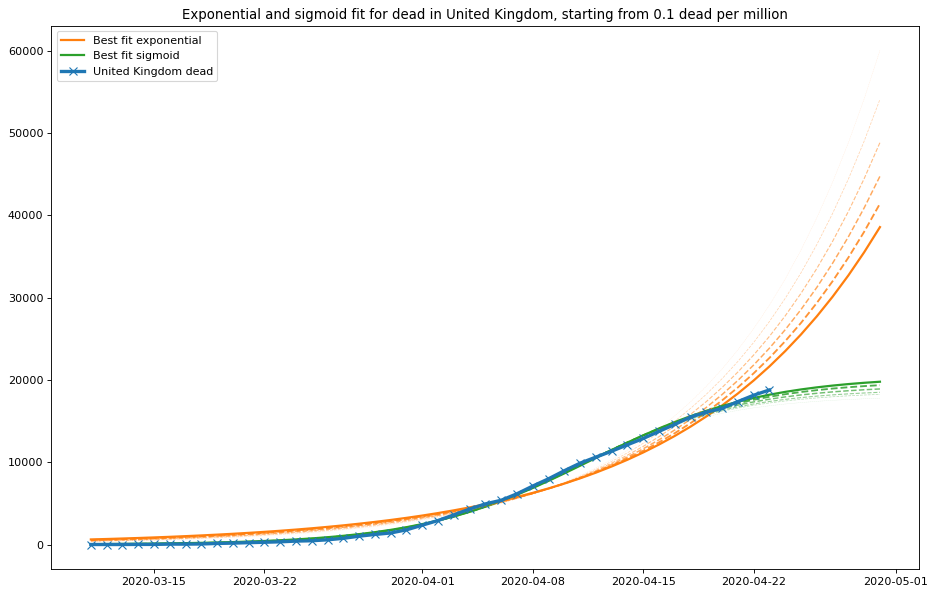

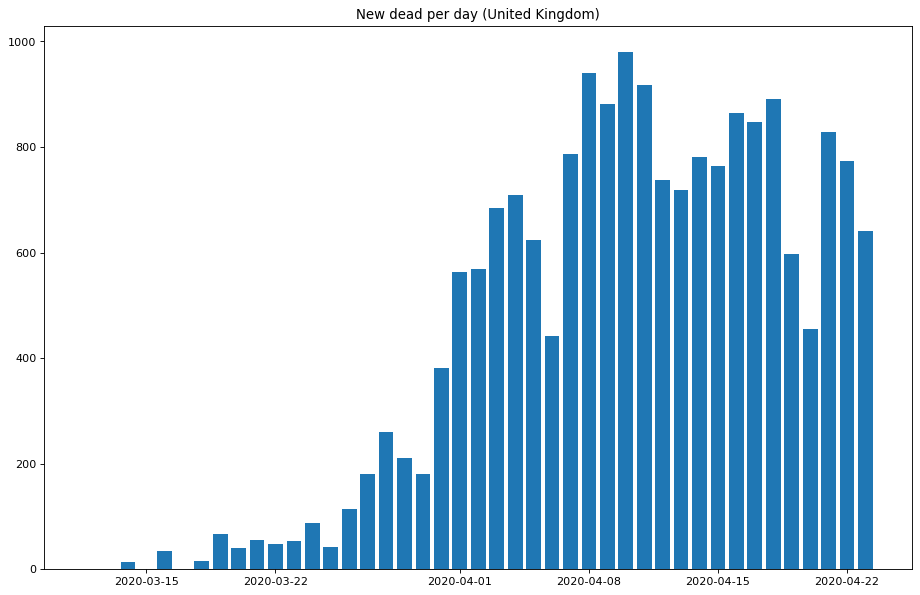

### Active

Start date 2020-03-04 (1st day with 1 active per million)

Latest number \\(119,743\\) on 2020-04-23

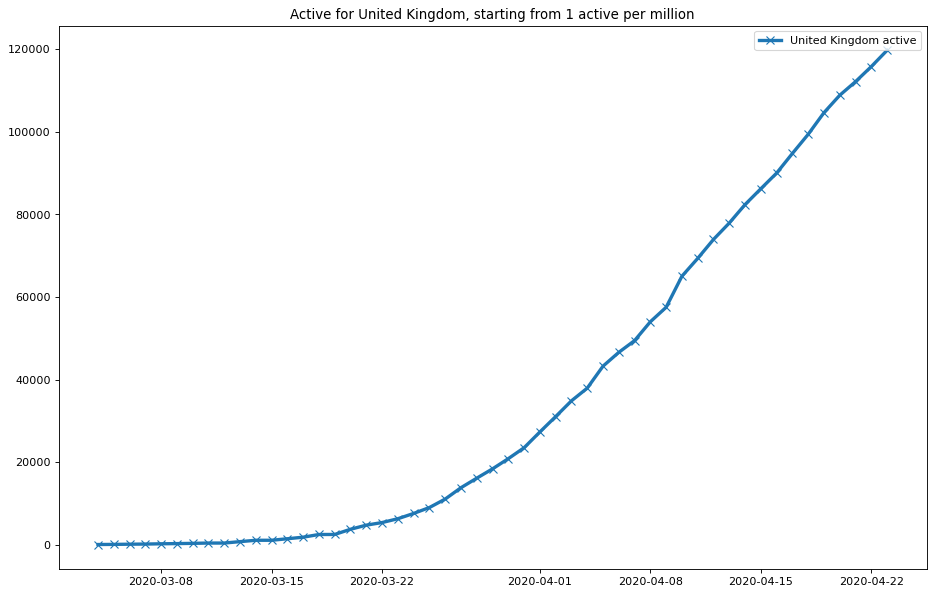

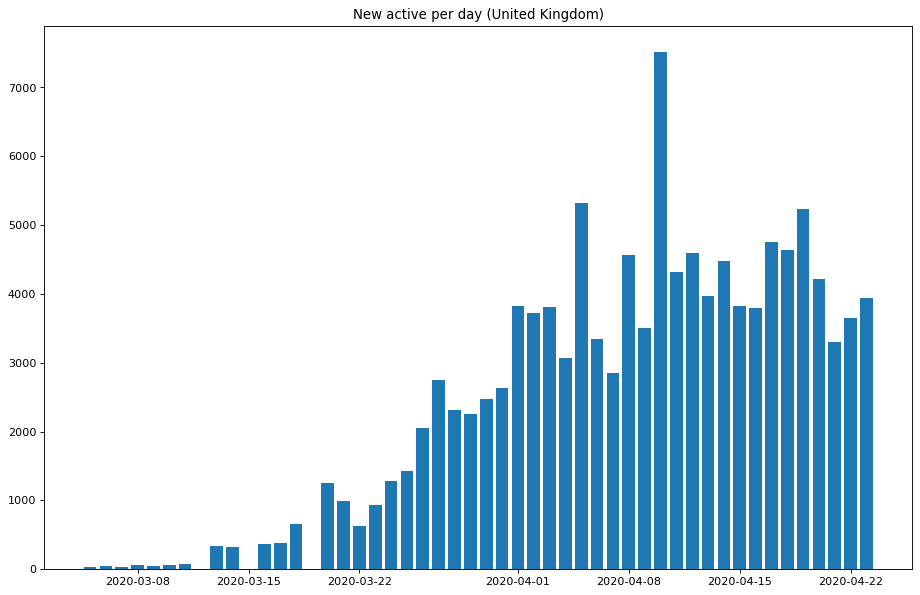

## Sweden

Population \\(10,099,265\\)

### Confirmed

Start date 2020-02-29 (1st day with 1 confirmed per million)

Latest number \\(16,755\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

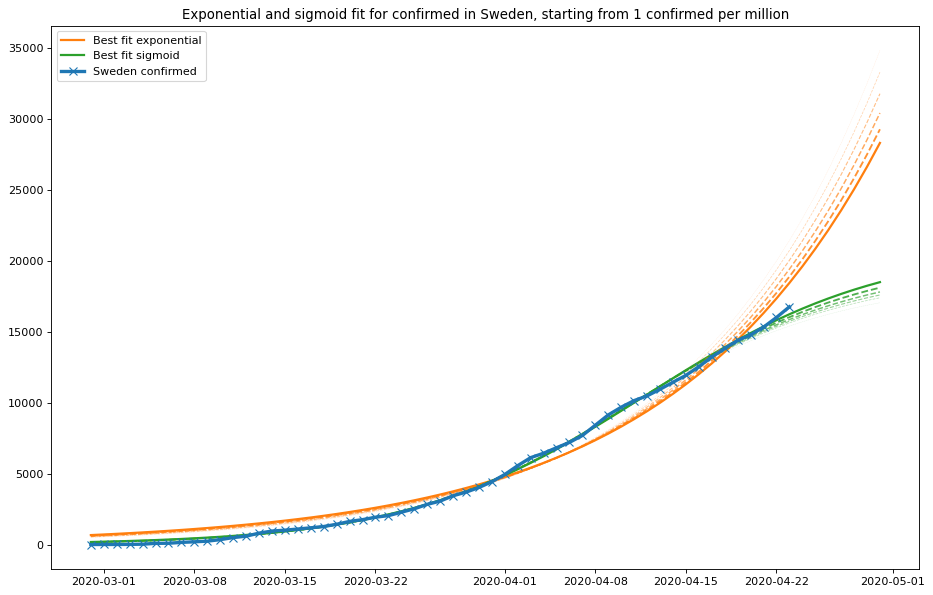

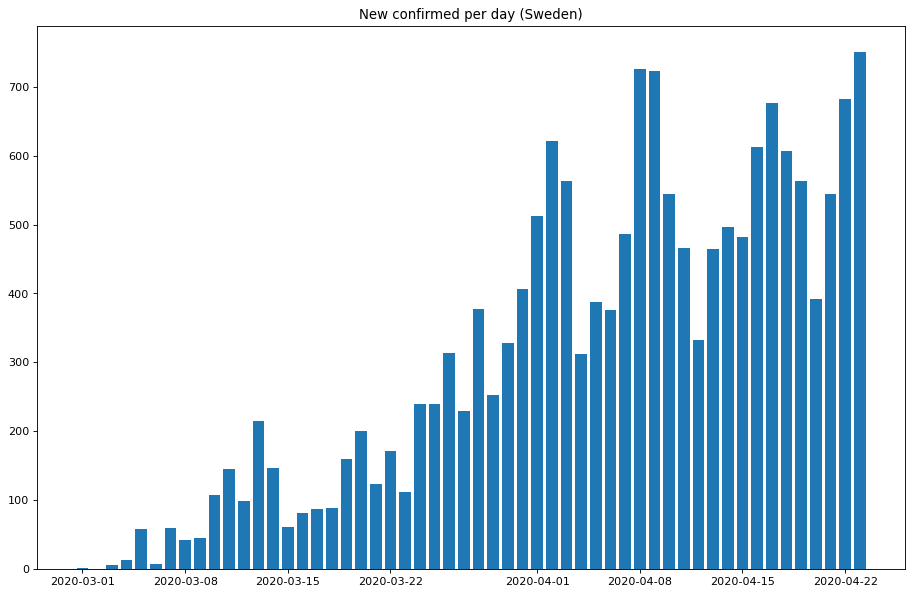

### Dead

Start date 2020-03-14 (1st day with 0.1 dead per million)

Latest number \\(2,021\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

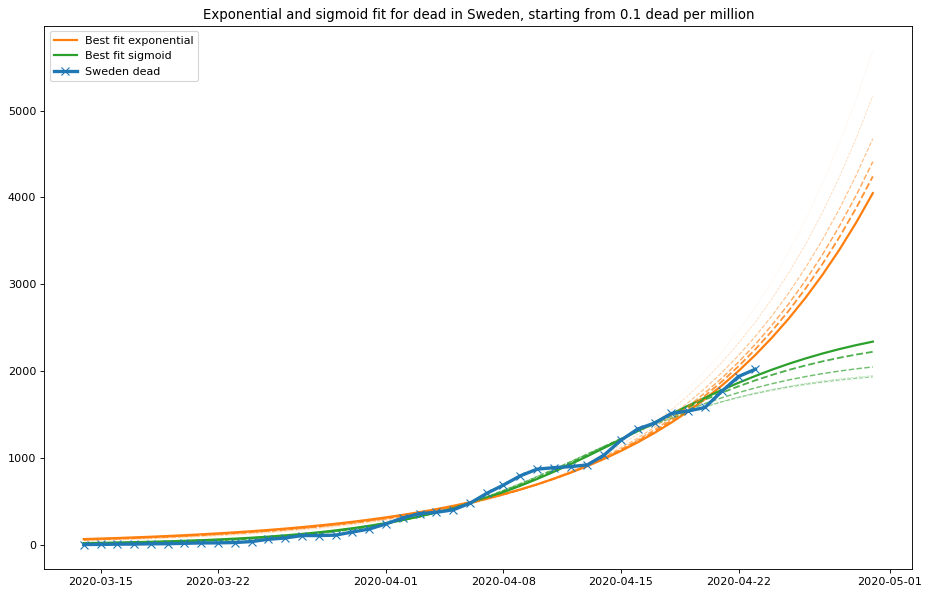

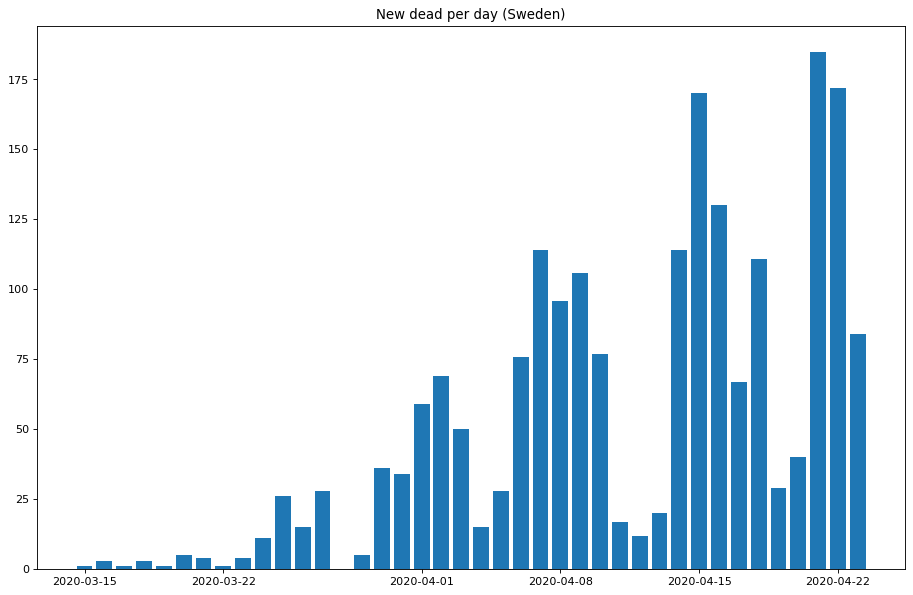

### Active

Start date 2020-02-29 (1st day with 1 active per million)

Latest number \\(14,184\\) on 2020-04-23

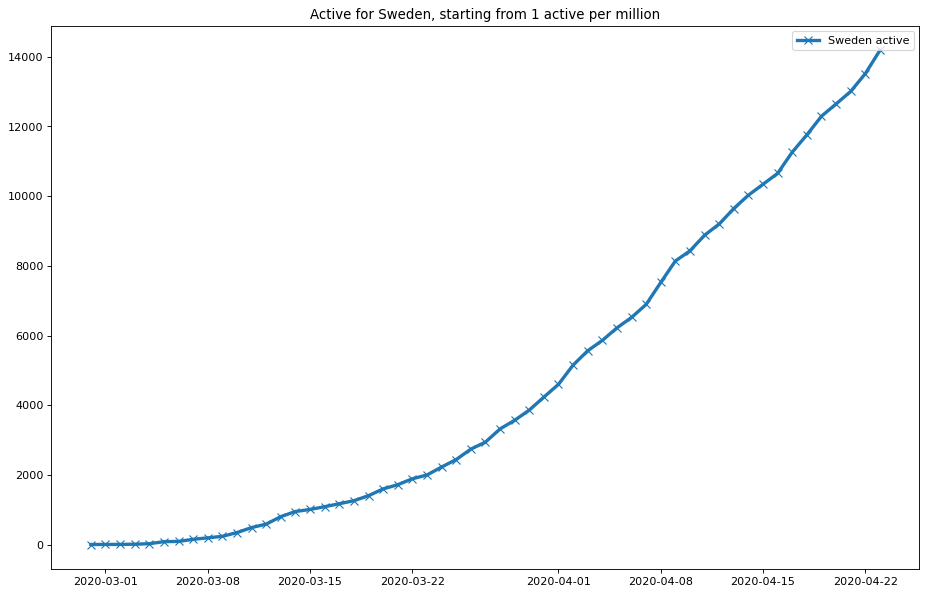

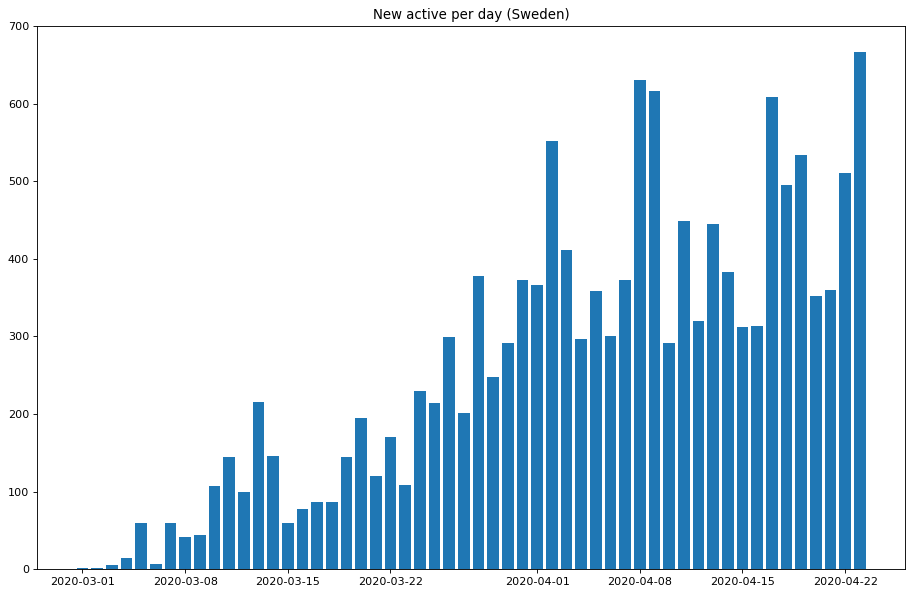

In [6]:
for country in countries_to_plot:
    country_deep_dive(country)

# Recovering countries that had over 300 active cases at peak

## List of all recovering countries (the top 4 not covered above are also analyzed below)

China recovered 98%
Iceland recovered 75%
Thailand recovered 75%
Korea, South recovered 74%
Austria recovered 70%
New Zealand recovered 63%
Switzerland recovered 56%
Iran recovered 52%
Burkina Faso recovered 49%
Taiwan* recovered 46%
Denmark recovered 40%
Germany recovered 39%
Iraq recovered 38%
Malta recovered 32%
Azerbaijan recovered 32%
Andorra recovered 30%
Malaysia recovered 24%
Croatia recovered 17%
Costa Rica recovered 14%
Czechia recovered 11%
Israel recovered 8%
Lebanon recovered 6%


## China

Population \\(1,439,323,776\\)

### Confirmed

Start date 2020-01-26 (1st day with 1 confirmed per million)

Latest number \\(83,884\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

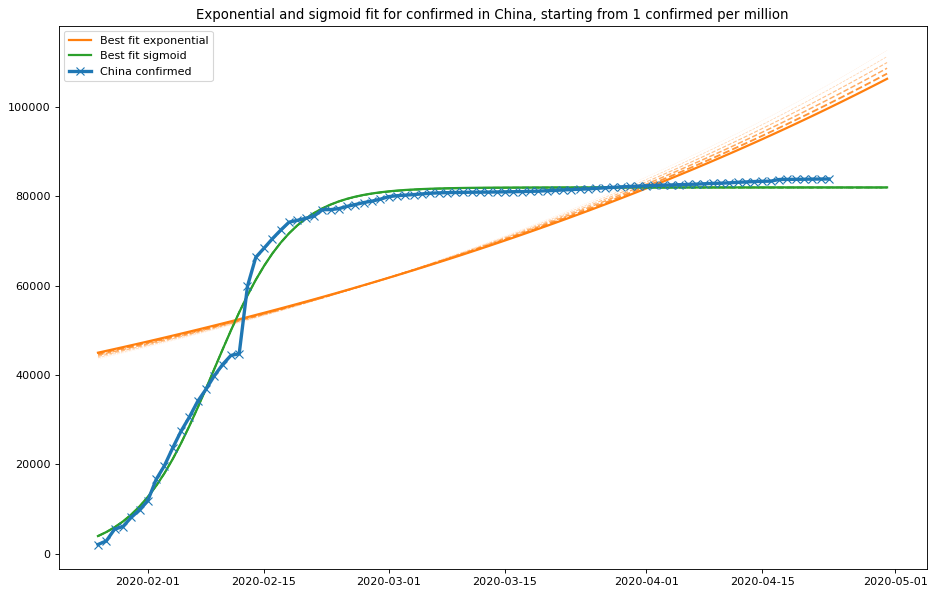

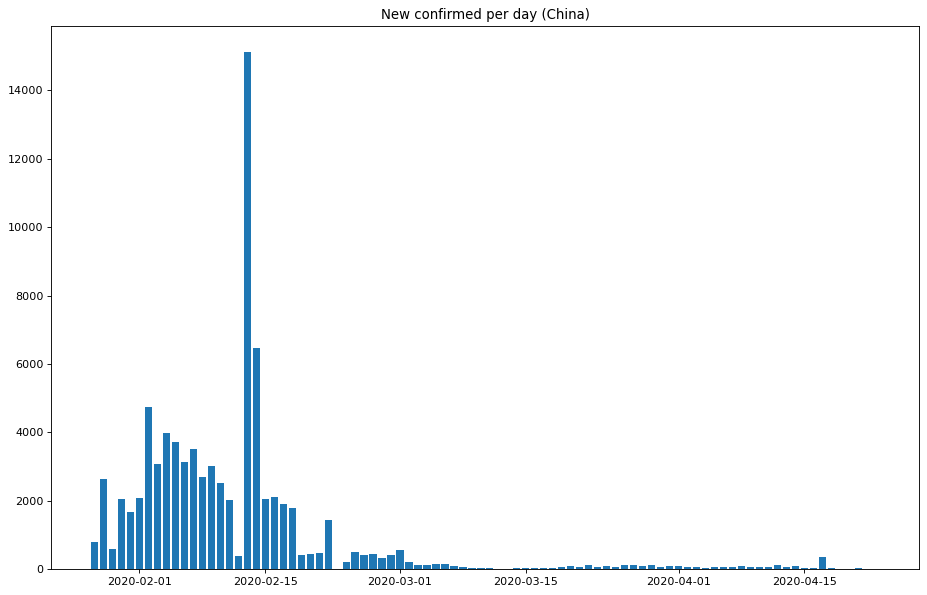

### Dead

Start date 2020-01-30 (1st day with 0.1 dead per million)

Latest number \\(4,636\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

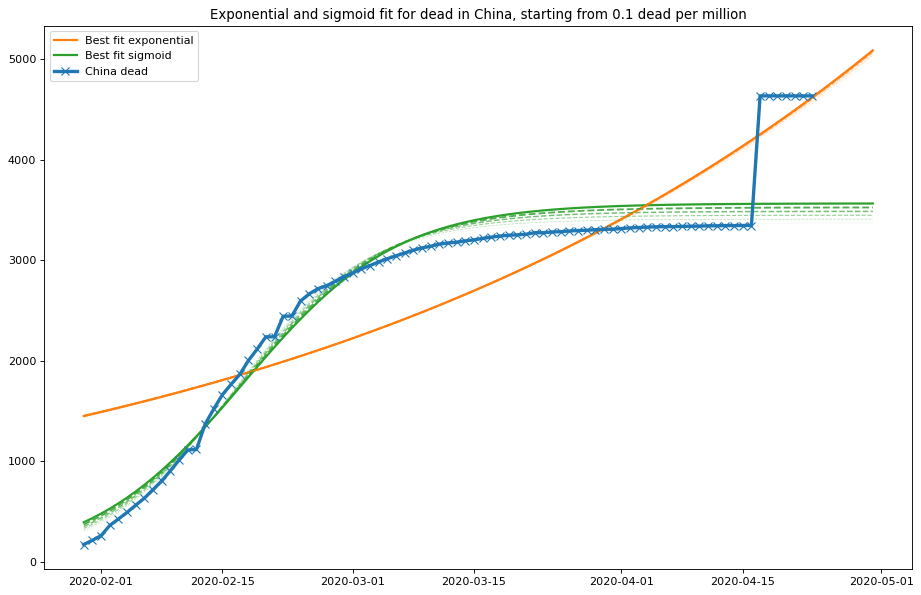

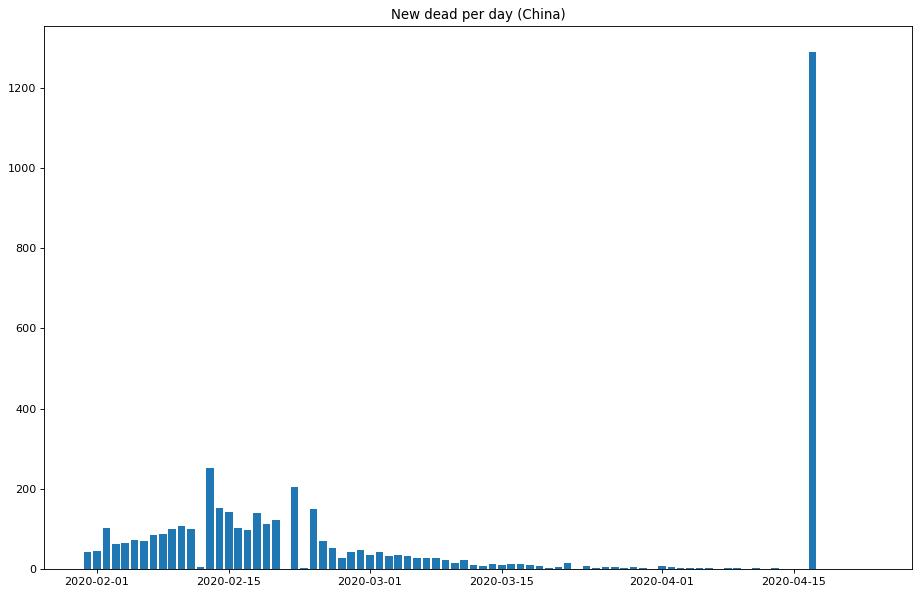

### Active

Start date 2020-01-26 (1st day with 1 active per million)

Latest number \\(1,265\\) on 2020-04-23

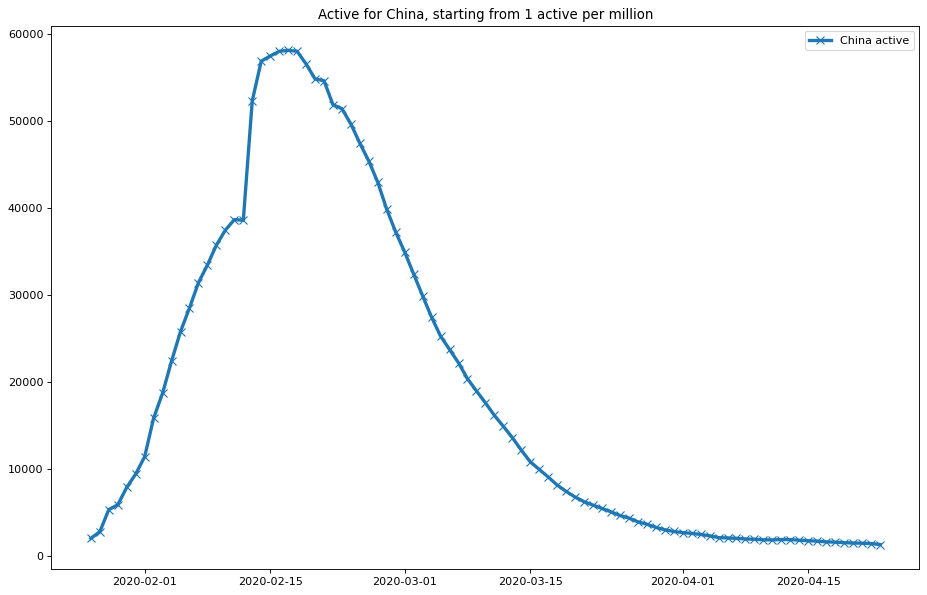

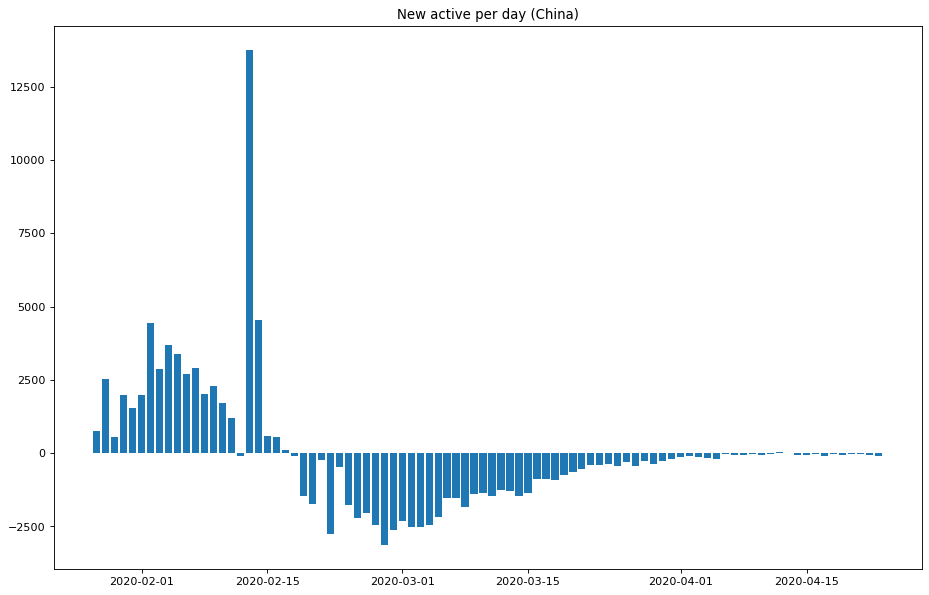

## Iceland

Population \\(341,243\\)

### Confirmed

Start date 2020-02-28 (1st day with 1 confirmed per million)

Latest number \\(1,789\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

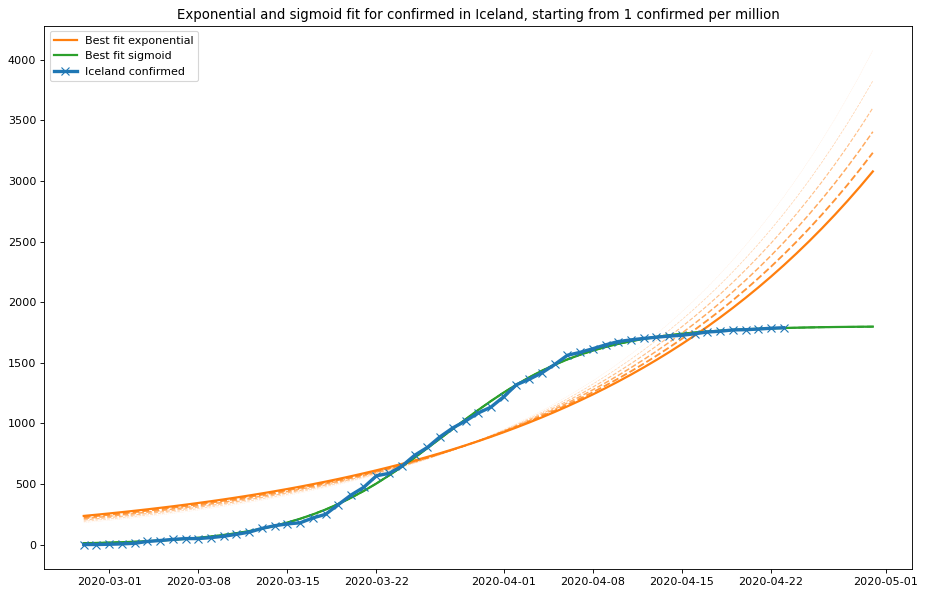

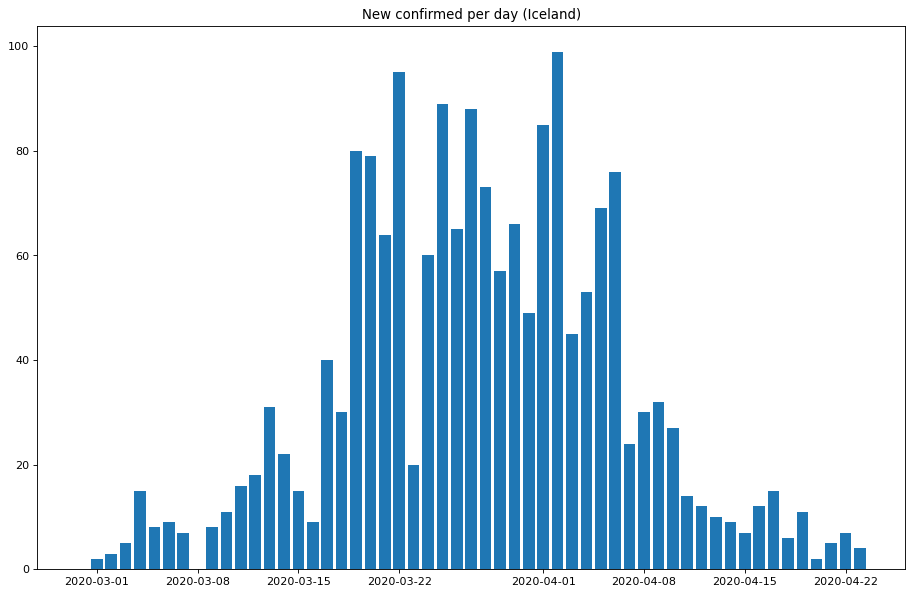

### Dead

Start date 2020-03-15 (1st day with 0.1 dead per million)

Latest number \\(10\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

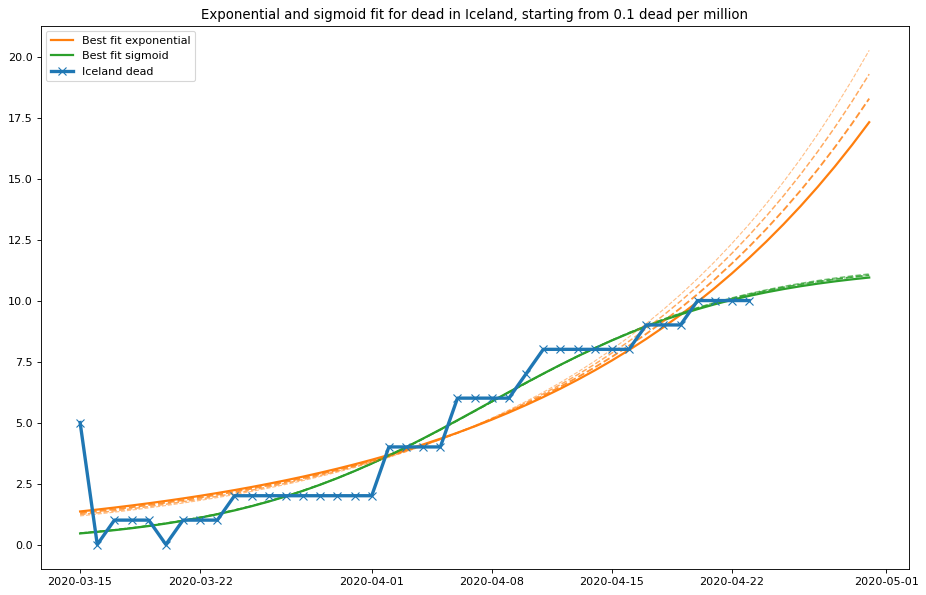

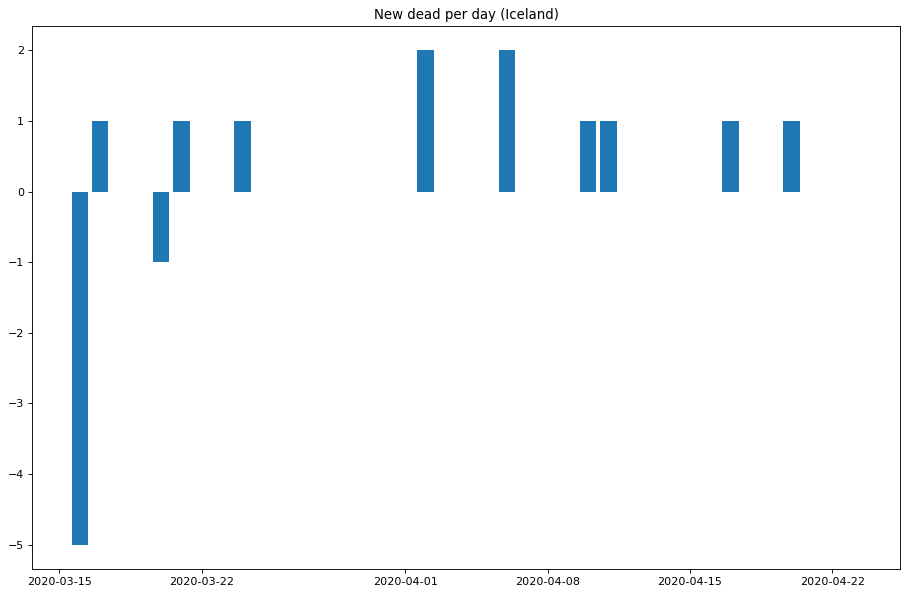

### Active

Start date 2020-02-28 (1st day with 1 active per million)

Latest number \\(270\\) on 2020-04-23

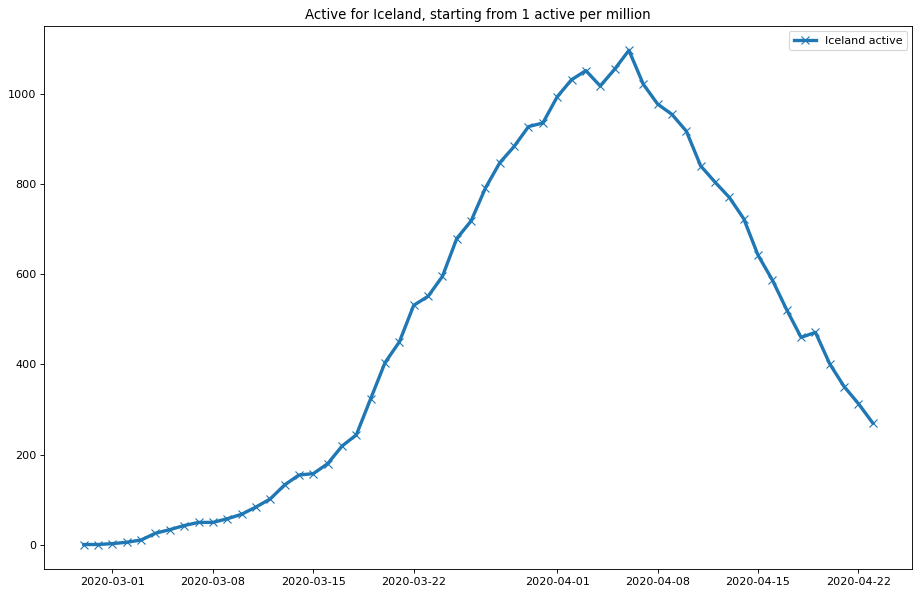

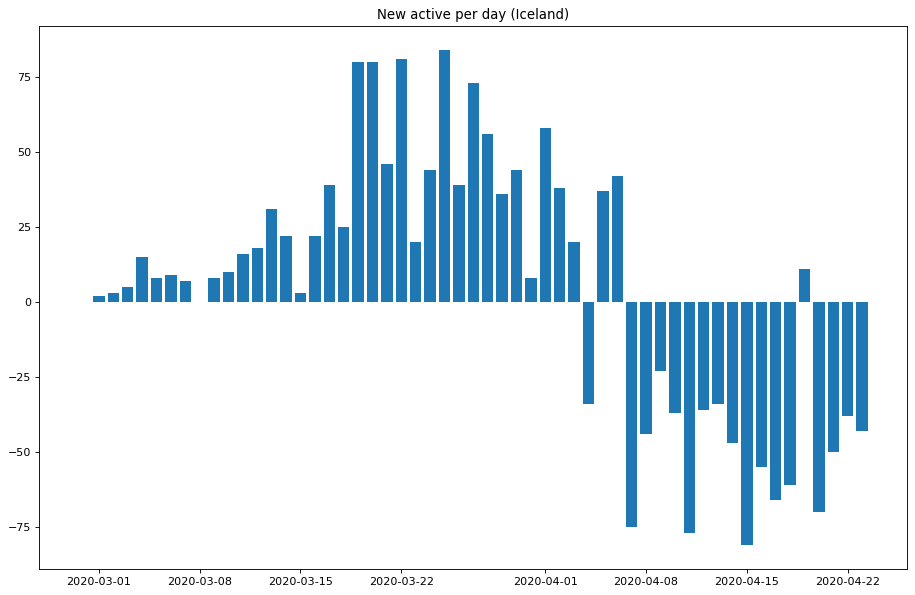

## Thailand

Population \\(69,799,978\\)

### Confirmed

Start date 2020-03-12 (1st day with 1 confirmed per million)

Latest number \\(2,839\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

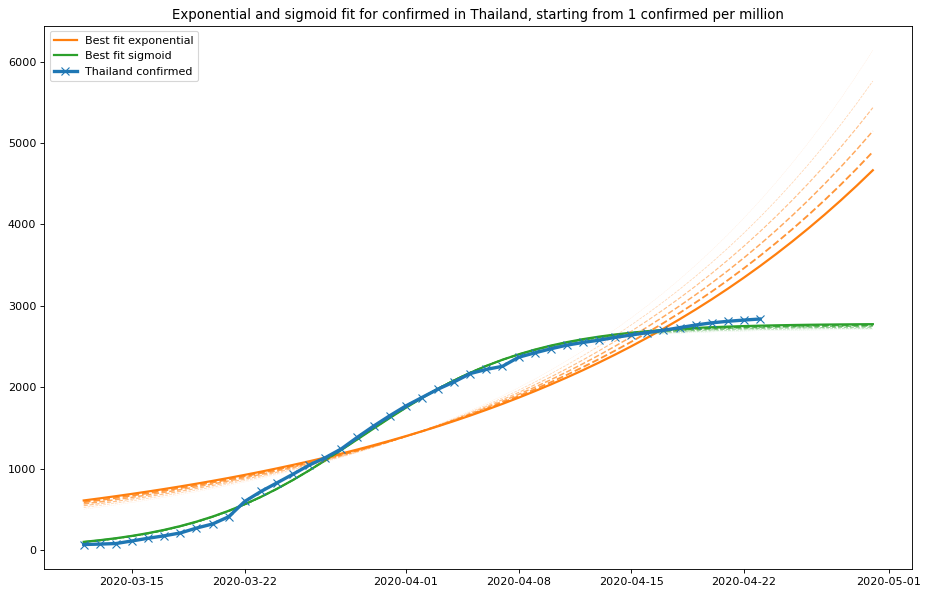

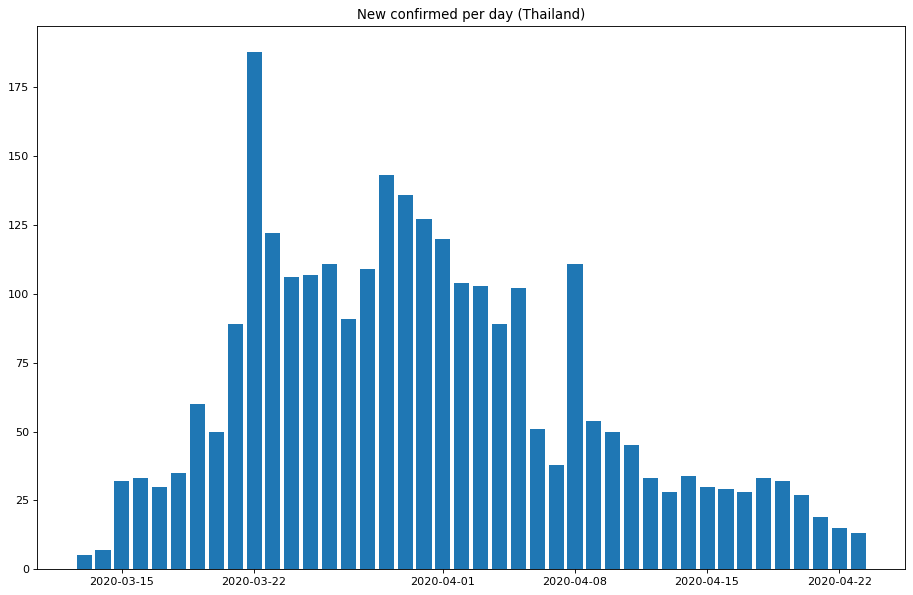

### Dead

Start date 2020-03-29 (1st day with 0.1 dead per million)

Latest number \\(50\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

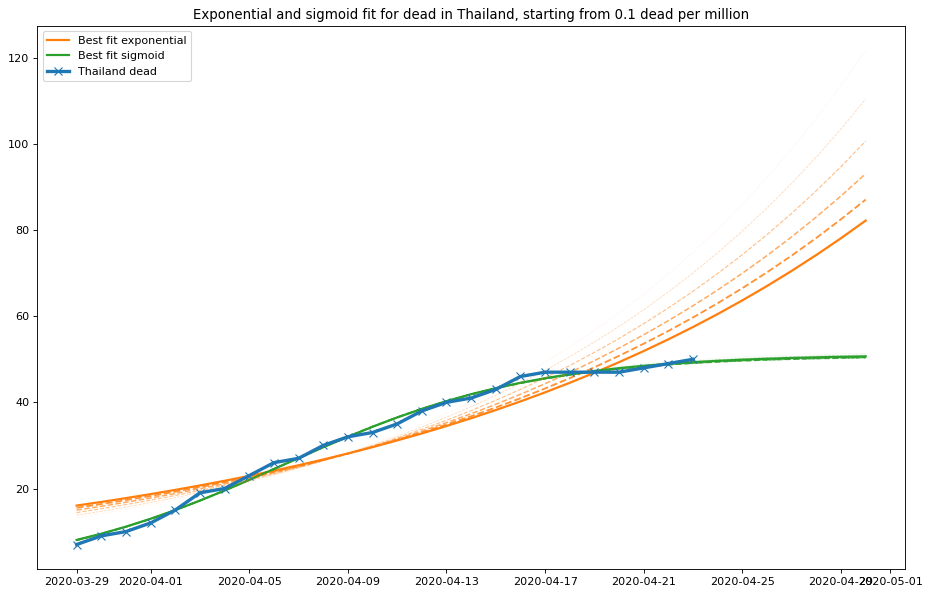

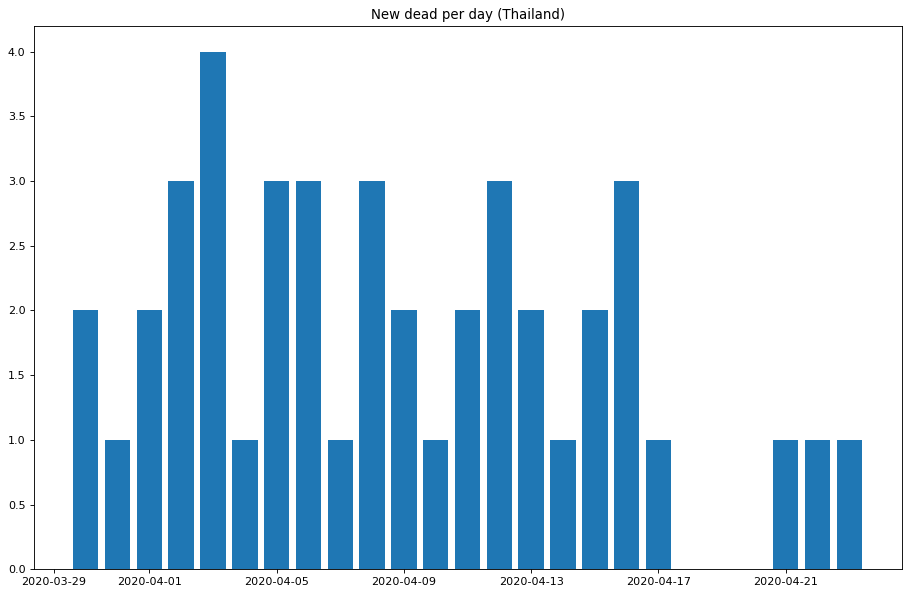

### Active

Start date 2020-03-15 (1st day with 1 active per million)

Latest number \\(359\\) on 2020-04-23

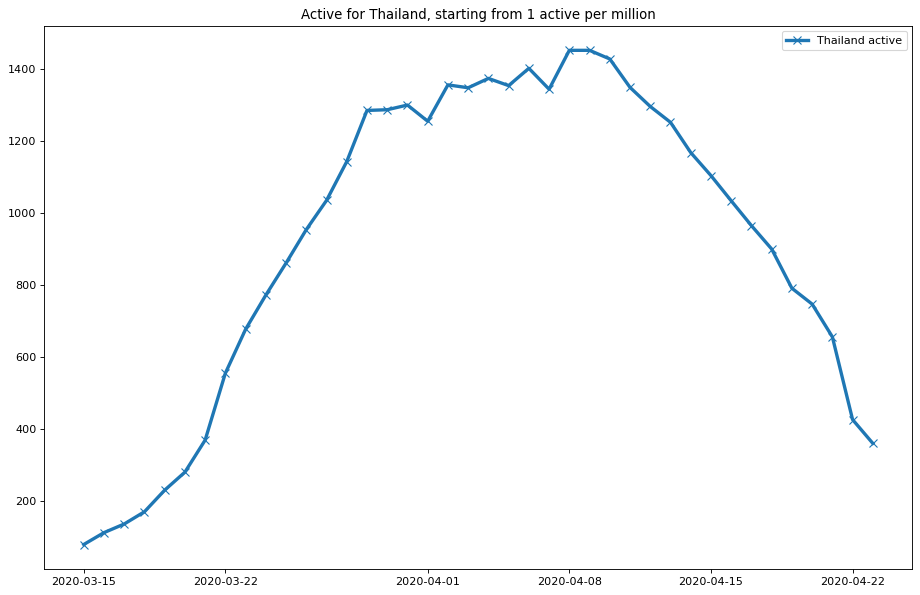

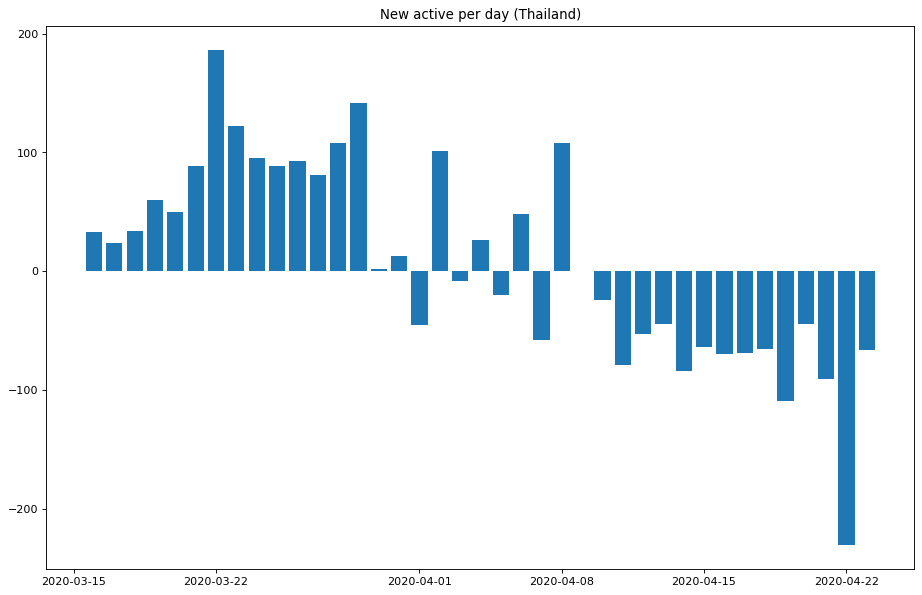

## Korea, South

Population \\(51,269,185\\)

### Confirmed

Start date 2020-02-20 (1st day with 1 confirmed per million)

Latest number \\(10,708\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

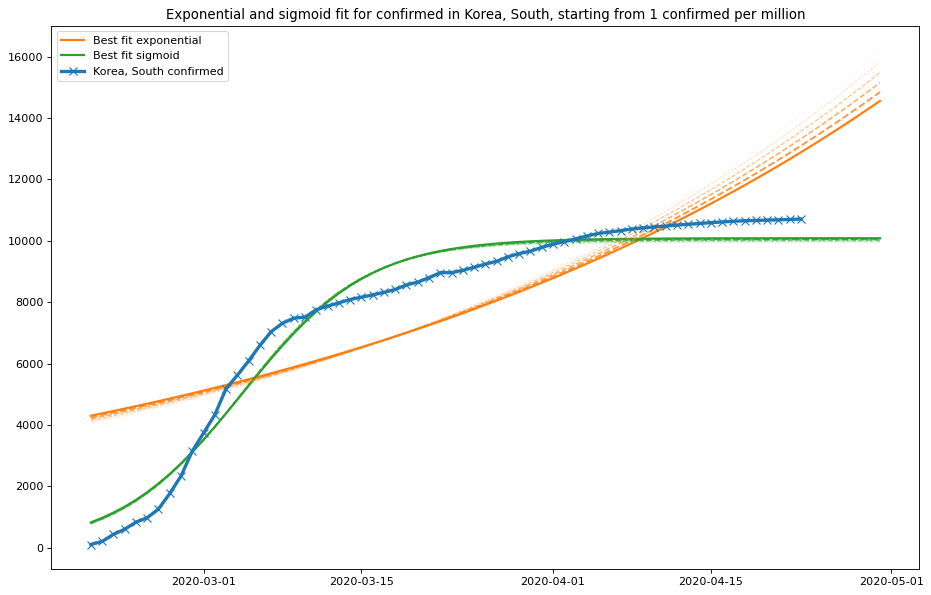

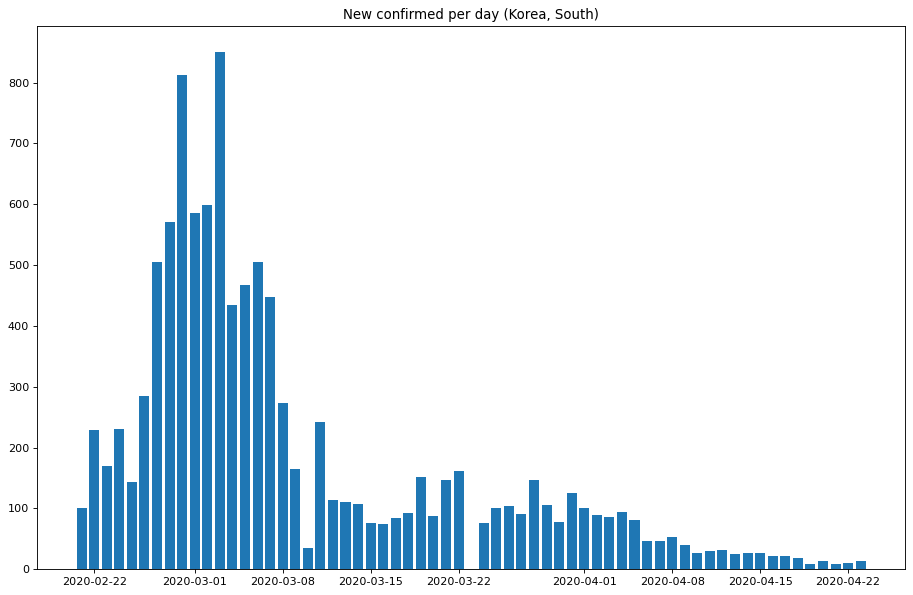

### Dead

Start date 2020-02-23 (1st day with 0.1 dead per million)

Latest number \\(240\\) on 2020-04-23

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

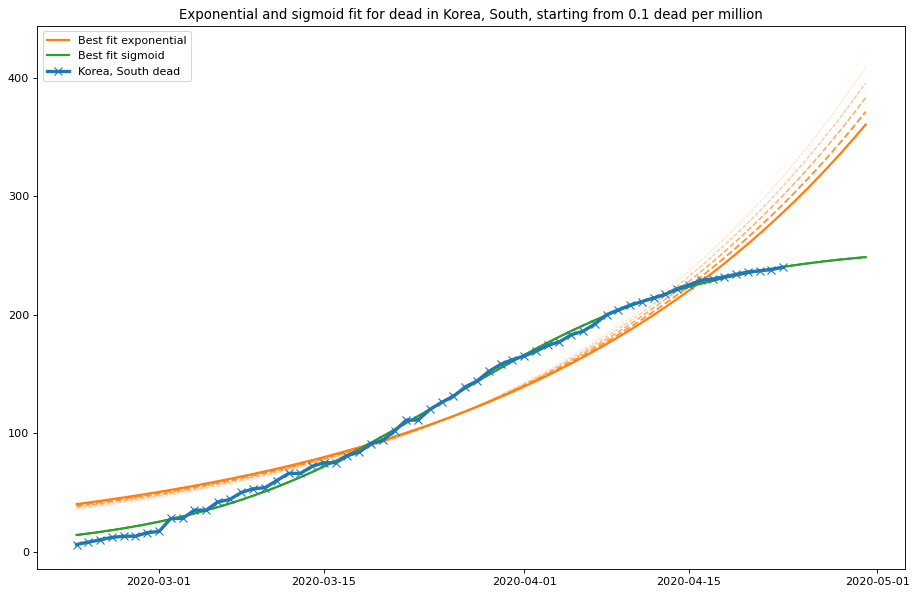

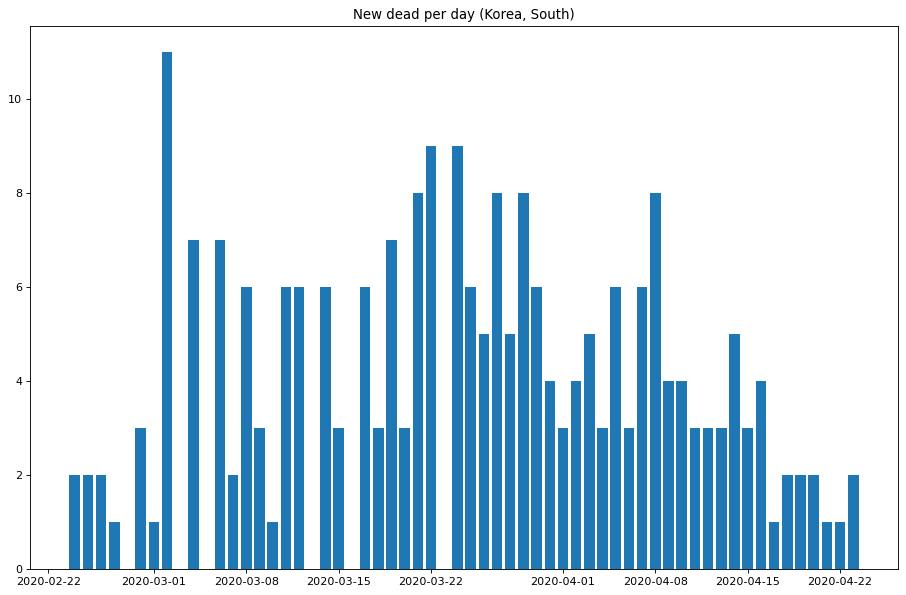

### Active

Start date 2020-02-20 (1st day with 1 active per million)

Latest number \\(1,967\\) on 2020-04-23

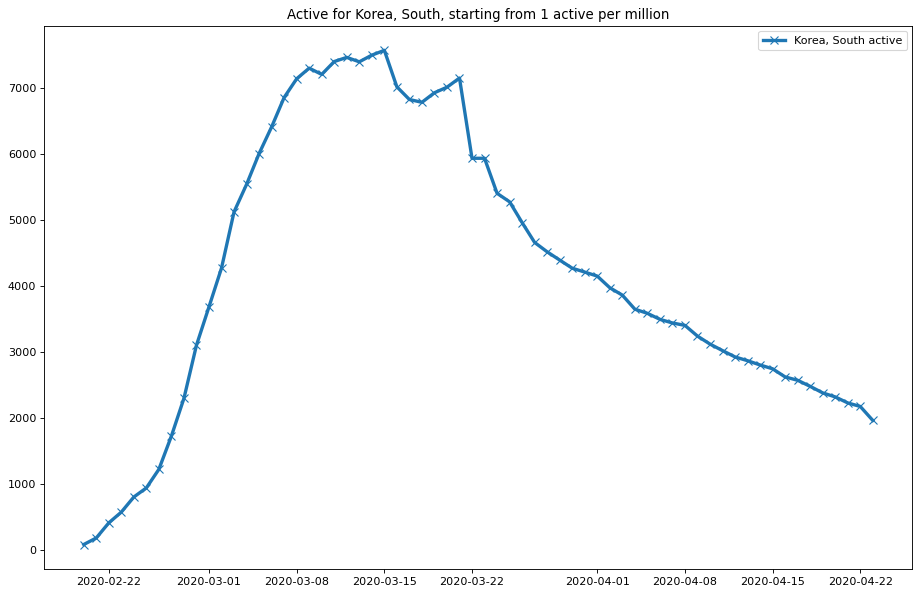

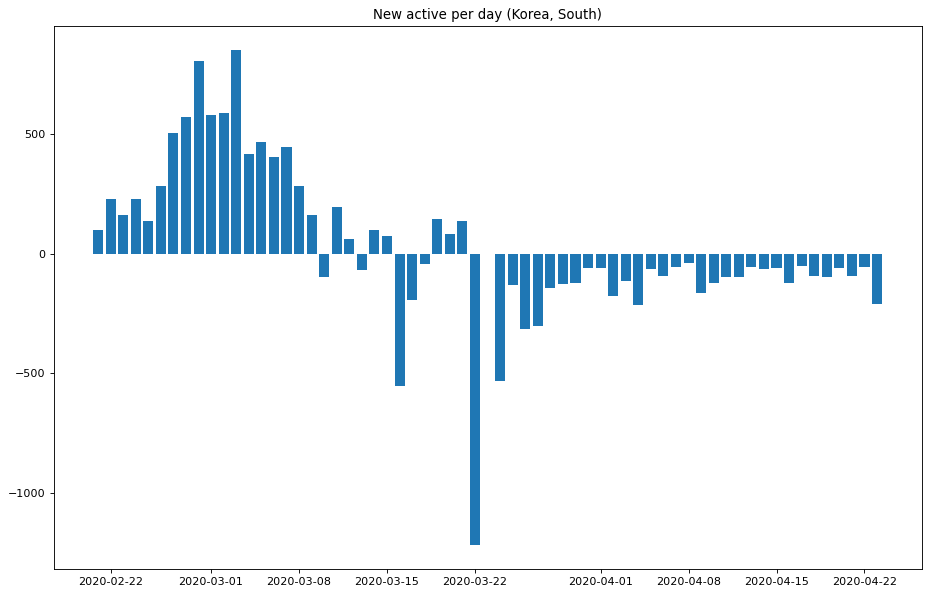

In [7]:
draw_recovering_countries(get_recovering_countries_info())